# Audio Hybrid Neuroevolution Notebook

This notebook implements a hybrid neuroevolution process for audio classification (Parkinson detection). The system combines genetic algorithms with 1D convolutional neural networks to evolve optimal architectures for audio processing.

## Main Features:
- **Hybrid genetic algorithm**: Combines architecture and weight evolution
- **1D Convolutional Networks**: Optimized for audio waveform processing
- **Parallel 5-Fold Cross-Validation**: Each individual is evaluated on all 5 folds IN PARALLEL (fitness = average accuracy)
- **Multi-threading**: Folds are trained simultaneously in separate threads for faster evaluation
- **Adaptive mutation**: Dynamic mutation rate based on population diversity
- **Audio dataset support**: Loads .npy files with train/val/test splits
- **Intelligent stopping criteria**: By target fitness or maximum generations
- **Complete visualization**: Shows progress and final best architecture

## Objectives:
1. Create initial population of 1D CNN architectures
2. Evaluate fitness of each individual using **parallel 5-fold CV** (robust and faster with threading)
3. Select best architectures (elitism)
4. Apply crossover and mutation to create new generation
5. Repeat process until convergence
6. Display the best architecture found for Parkinson classification

**✅ Performance**: Multi-threaded 5-fold CV provides robustness against overfitting while being much faster than sequential training.


---
## ✨ CONFIGURACIÓN ACTUAL DEL DATASET ✨

**Dataset configurado**: `files_all_real_syn_n` (Datos Reales + Sintéticos Mezclados)

Este notebook está configurado para usar el **nuevo dataset** que combina:
- 🎵 **Datos Reales**: Audios originales de pacientes  
- 🤖 **Datos Sintéticos**: Audios generados por GANs (BigVSAN 40_1e5)

**Ventajas de este dataset**:
- Mayor diversidad de datos para entrenamiento
- Combina la autenticidad de datos reales con la variedad de datos generados
- Ideal para mejorar la generalización del modelo
- Estratificación balanceada entre clases (control/patológico)

**🚀 Parallel 5-Fold Cross-Validation durante la Evolución**: 
- **CADA** individuo se evalúa en **TODOS** los 5 folds **EN PARALELO**
- Los 5 folds se entrenan **simultáneamente** en threads separados
- El fitness es el **promedio** de accuracy de los 5 folds
- ✅ **Mucho más rápido** que entrenamiento secuencial
- ✅ **Más robusto** - evita sobreajuste a un fold específico

**📊 Evaluación Final**: 
- Al terminar la evolución, la mejor arquitectura se vuelve a evaluar con 5-fold CV
- Se reportan métricas completas (accuracy, sensitivity, specificity, F1, AUC)

Para cambiar el dataset, modifica los parámetros `dataset_id` y `fold_id` en la celda de **Configuración** (Sección 2).

---

## 1. Required Libraries Import

In [1]:
# Install all necessary libraries
import subprocess
import sys

def install_package(package):
    """Installs a package using pip if not available."""
    try:
        __import__(package.split('==')[0].split('[')[0])
        print(f"OK {package.split('==')[0]} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"OK {package} installed correctly")

# List of required packages
required_packages = [
    "torch>=2.0.0",
    "torchvision>=0.15.0",
    "numpy>=1.21.0",
    "matplotlib>=3.5.0",
    "seaborn>=0.11.0",
    "tqdm>=4.64.0",
    "jupyter>=1.0.0",
    "ipywidgets>=8.0.0"
]

print("Starting dependency installation for Hybrid Neuroevolution...")
print("=" * 60)

for package in required_packages:
    install_package(package)

print("\nAll dependencies have been verified/installed")
print("Restart the kernel if this is the first time installing torch")
print("=" * 60)

# Verify PyTorch installation
try:
    import torch
    print(f"\nPyTorch {torch.__version__} installed correctly")
    print(f"CUDA available: {'Yes' if torch.cuda.is_available() else 'No'}")
    if torch.cuda.is_available():
        print(f"GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
except ImportError:
    print("ERROR: PyTorch could not be installed correctly")
    print("Try installing manually with: pip install torch torchvision")

Starting dependency installation for Hybrid Neuroevolution...
Installing torch>=2.0.0...


OK torch>=2.0.0 installed correctly
Installing torchvision>=0.15.0...


OK torchvision>=0.15.0 installed correctly
Installing numpy>=1.21.0...


OK numpy>=1.21.0 installed correctly
Installing matplotlib>=3.5.0...


OK matplotlib>=3.5.0 installed correctly
Installing seaborn>=0.11.0...


OK seaborn>=0.11.0 installed correctly
Installing tqdm>=4.64.0...


OK tqdm>=4.64.0 installed correctly
Installing jupyter>=1.0.0...


OK jupyter>=1.0.0 installed correctly
Installing ipywidgets>=8.0.0...


OK ipywidgets>=8.0.0 installed correctly

All dependencies have been verified/installed
Restart the kernel if this is the first time installing torch

PyTorch 2.8.0+cu128 installed correctly
CUDA available: Yes
GPU detected: NVIDIA A100-PCIE-40GB MIG 7g.40gb
GPU memory: 39 GB


In [2]:
# Main imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Scientific libraries
import numpy as np
import random
import copy
import json
import os
from typing import Dict, List, Tuple, Any
from datetime import datetime
import uuid

# Threading for parallel fold training
import threading
from queue import Queue
from concurrent.futures import ThreadPoolExecutor, as_completed

# Visualization and progress
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configure seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device configured: {device}")
print(f"PyTorch version: {torch.__version__}")

# Suppress unnecessary warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

Device configured: cuda
PyTorch version: 2.8.0+cu128


## 2. System Configuration and Parameters

In [3]:
# Main genetic algorithm configuration (updated for adaptive mutation & moderate elitism)
CONFIG = {
    # Genetic algorithm parameters
    'population_size': 20,            # Population size
    'max_generations': 100,            # Maximum number of generations
    'fitness_threshold': 80.0,        # Target fitness (% accuracy) - Adjusted for audio

    # Adaptive mutation parameters
    'base_mutation_rate': 0.25,       # Starting mutation rate (moderate)
    'mutation_rate_min': 0.10,        # Lower bound for adaptive mutation
    'mutation_rate_max': 0.80,        # Upper bound for adaptive mutation
    'current_mutation_rate': 0.25,    # Will be updated dynamically each generation

    'crossover_rate': 0.99,           # Crossover rate
    'elite_percentage': 0.2,          # Moderate elitism (20%) instead of 40%

    # Dataset selection (AUDIO ONLY)
    'dataset': 'AUDIO',               # Audio dataset for Parkinson classification

    # Dataset parameters for audio
    'num_channels': 1,                # Input channels (1 for audio waveform)
    'sequence_length': 240000,        # Audio sequence length (will be auto-detected)
    'num_classes': 2,                 # Number of classes (control vs pathological)
    'batch_size': 64,                 # Batch size for audio
    'test_split': 0.2,                # Validation percentage

    # Training parameters
    'num_epochs': 100,                 # Max training epochs per evaluation (may stop earlier)
    'learning_rate': 0.00001,           # Base learning rate
    'early_stopping_patience': 100000,   # Max batches per epoch (quick partial epoch)

    # Epoch-level early stopping
    'epoch_patience': 10,              # Stop if no significant improvement after N evaluations
    'improvement_threshold': 0.01,     # Minimum (absolute) accuracy gain (%) to reset patience

    # Generation-level early stopping 
    'early_stopping_generations': 20, # Stop if no improvement in X generations
    'min_improvement_threshold': 0.01, # Minimum fitness improvement (%) to reset counter

    # Allowed architecture range for 1D Conv
    'min_conv_layers': 1,
    'max_conv_layers': 30,             # Less layers for 1D audio
    'min_fc_layers': 1,
    'max_fc_layers': 10,               # Less FC layers
    'min_filters': 1,
    'max_filters': 256,               # Adjusted for 1D
    'min_fc_nodes': 64,
    'max_fc_nodes': 1024,              # Smaller for audio classification

    # Mutation parameters - Kernel sizes for 1D Conv
    'kernel_size_options': [1, 3, 5, 7, 9, 11, 13, 15],  # Available kernel sizes for Conv1D
    
    # Mutation parameters - Dropout range
    'min_dropout': 0.2,               # Minimum dropout rate
    'max_dropout': 0.6,               # Maximum dropout rate
    
    # Mutation parameters - Learning rate options
    'learning_rate_options': [0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.01, 0.1, 0.00001 ],  # Available learning rates
    
    # Mutation parameters - Normalization type weights
    'normalization_batch_weight': 0.8,  # Probability to use batch normalization
    'normalization_layer_weight': 0.2,  # Probability to use layer normalization

    # Audio dataset configuration (OS-independent paths)
    
    'dataset_id': 'all_real_syn_n',   # Dataset ID - Mixed real + synthetic data
    'fold_id': 'all_real_syn_n',      # Fold ID for files
    'num_folds': 5,                   # Number of folds (all used during evolution)
    'data_path': os.path.join('data', 'sets', 'folds_5'),  # OS-independent path
    'normalization': {'mean': (0.0,), 'std': (1.0,)}  # Audio normalization
}

# Activation function mapping
ACTIVATION_FUNCTIONS = {
    'relu': nn.ReLU,
    'leaky_relu': nn.LeakyReLU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'selu': nn.SELU,
}

# Optimizer mapping
OPTIMIZERS = {
    'adam': optim.Adam,
    'adamw': optim.AdamW,
    'sgd': optim.SGD,
    'rmsprop': optim.RMSprop,
}

print("Configuration loaded (adaptive mutation enabled, 1D Conv for audio):")
print(f"   Dataset: Audio (Parkinson Classification)")
for key, value in CONFIG.items():
    if key not in ['normalization']:  # Hide normalization details
        print(f"   {key}: {value}")
print(f"\nAvailable activation functions: {list(ACTIVATION_FUNCTIONS.keys())}")
print(f"Available optimizers: {list(OPTIMIZERS.keys())}")
print(f"\nOS-independent path configured: {CONFIG['data_path']}")


Configuration loaded (adaptive mutation enabled, 1D Conv for audio):
   Dataset: Audio (Parkinson Classification)
   population_size: 20
   max_generations: 100
   fitness_threshold: 80.0
   base_mutation_rate: 0.25
   mutation_rate_min: 0.1
   mutation_rate_max: 0.8
   current_mutation_rate: 0.25
   crossover_rate: 0.99
   elite_percentage: 0.2
   dataset: AUDIO
   num_channels: 1
   sequence_length: 240000
   num_classes: 2
   batch_size: 64
   test_split: 0.2
   num_epochs: 100
   learning_rate: 1e-05
   early_stopping_patience: 100000
   epoch_patience: 10
   improvement_threshold: 0.01
   early_stopping_generations: 20
   min_improvement_threshold: 0.01
   min_conv_layers: 1
   max_conv_layers: 30
   min_fc_layers: 1
   max_fc_layers: 10
   min_filters: 1
   max_filters: 256
   min_fc_nodes: 64
   max_fc_nodes: 1024
   kernel_size_options: [1, 3, 5, 7, 9, 11, 13, 15]
   min_dropout: 0.2
   max_dropout: 0.6
   learning_rate_options: [0.001, 0.0005, 0.0001, 5e-05, 1e-05, 0.01, 0.1, 

### 📋 Parámetros de Mutación Configurables

**Todos los parámetros de mutación ahora son configurables desde `CONFIG`**:

#### Kernel Sizes (Tamaños de kernel para Conv1D)
- **`kernel_size_options`**: `[3, 5, 7, 9, 11, 13, 15]`
  - Opciones disponibles para los tamaños de kernel en capas convolucionales 1D
  - Se usa tanto en la creación inicial como en la mutación

#### Dropout Range (Rango de dropout)
- **`min_dropout`**: `0.2` - Tasa mínima de dropout
- **`max_dropout`**: `0.6` - Tasa máxima de dropout
  - Durante la creación y mutación, el dropout se selecciona aleatoriamente dentro de este rango

#### Learning Rate Options (Opciones de learning rate)
- **`learning_rate_options`**: `[0.001, 0.0005, 0.0001, 0.00005, 0.00001]`
  - Opciones disponibles para el learning rate
  - Se selecciona aleatoriamente de esta lista durante creación y mutación

#### Normalization Type Weights (Pesos para tipo de normalización)
- **`normalization_batch_weight`**: `0.8` - Probabilidad de usar batch normalization (80%)
- **`normalization_layer_weight`**: `0.2` - Probabilidad de usar layer normalization (20%)
  - Durante la mutación, se selecciona el tipo de normalización con estas probabilidades

✅ **Beneficio**: Ahora puedes ajustar todos estos parámetros desde un solo lugar (CONFIG) sin modificar las funciones de mutación o creación de genomas.

### Información sobre el Dataset de Audio

**Dataset de Audio para Clasificación de Parkinson**: 
- Archivos de audio de voz (clasificación Parkinson)
- Datos 1D de forma de onda procesada
- Estructura: archivos .npy con train/val/test splits
- Dificultad: **Alta** - Clasificación médica
- Fitness objetivo recomendado: >85%
- Clases: Control vs Pathological
- Formato de archivos: `{data_path}/files_{fold_id}/X_train_{dataset_id}_fold_{fold}.npy`
- Arquitectura: Conv1D -> BatchNorm1D -> Activation -> MaxPool1D -> FC Layers

**Configuración del Dataset:**
- Modifica los parámetros en la celda de configuración:
  - `dataset_id`: ID del dataset (ej: 'all_real_syn_n')
  - `fold_id`: ID de la carpeta de folds (ej: 'all_real_syn_n')
  - `data_path`: Ruta base a los datos (usa `os.path.join` para compatibilidad multiplataforma)

**🔄 Uso de 5-Fold CV:**
- **Durante la evolución**: Cada individuo se evalúa en los 5 folds automáticamente
- **No se necesita** especificar `current_fold` (se usan todos)
- El fitness es el **promedio** de los 5 folds

**Nota sobre Rutas:**
- Las rutas son **independientes del sistema operativo** (Windows/Linux/Mac)
- Usa `os.path.join()` para construir rutas compatibles
- Ejemplo: `os.path.join('data', 'sets', 'folds_5')` funciona en cualquier OS

---

### Tipos de Carpetas de Folds Disponibles (generadas por `create_5_folds.ipynb`)

El notebook `generating_csv/create_5_folds.ipynb` genera **5 tipos de carpetas** con diferentes combinaciones de datos **reales** y **sintéticos** (generados por GANs) para experimentación:

#### 1. **`files_real_N`** - Solo Datos Reales
   - **Train**: Datos reales (`test_together_N`)
   - **Test**: Datos reales (`test_together_N`)
   - **Uso**: Baseline con datos 100% reales
   - **fold_id**: `'real_N'`
   - **dataset_id**: `'real_N'`

#### 2. **`files_real_40_1e5_N`** - Entrenamiento Sintético, Test Real
   - **Train**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Test**: Datos reales (`test_together_N`)
   - **Uso**: Evaluar si modelos entrenados con sintéticos generalizan a datos reales
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 3. **`files_syn_40_1e5_N`** - Solo Datos Sintéticos (mismo conjunto)
   - **Train**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Test**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Uso**: Evaluar capacidad del modelo con datos 100% sintéticos
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 4. **`files_syn_1_N`** - Entrenamiento Sintético, Test Sintético Diferente
   - **Train**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Test**: Datos sintéticos diferentes (`test_together_syn_1_N`)
   - **Uso**: Evaluar generalización entre diferentes conjuntos sintéticos
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 5. **`files_syn_all_N`** - Solo Datos Reales (mal nombrado probablemente)
   - **Train**: Datos reales (`test_together_N`)
   - **Test**: Datos reales (`test_together_N`)
   - **Uso**: Similar a `files_real_N` (posible duplicado o error de nomenclatura)
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 6. **`files_all_real_syn_n`** - ✨ Datos Reales + Sintéticos Mezclados ✨ **(NUEVO)**
   - **Train**: Datos reales + sintéticos mezclados
   - **Validation**: Datos reales + sintéticos mezclados
   - **Test**: Datos reales + sintéticos mezclados
   - **Uso**: Entrenar y evaluar con una mezcla equilibrada de datos reales y generados por GANs
   - **fold_id**: `'all_real_syn_n'`
   - **dataset_id**: `'all_real_syn_n'`
   - **Ventajas**: Combina diversidad de datos sintéticos con autenticidad de datos reales
   - **Configuración actual**: 🔵 **ESTE ES EL DATASET CONFIGURADO POR DEFECTO**

**Nota**: Cada carpeta contiene 5 folds de validación cruzada con:
- `X_train_{dataset_id}_fold_{1-5}.npy` y `y_train_{dataset_id}_fold_{1-5}.npy`
- `X_val_{dataset_id}_fold_{1-5}.npy` y `y_val_{dataset_id}_fold_{1-5}.npy`
- `X_test_{dataset_id}_fold_{1-5}.npy` y `y_test_{dataset_id}_fold_{1-5}.npy`

## 3. Dataset Loading and Preprocessing

In [4]:
def load_dataset(config: dict) -> Tuple[DataLoader, DataLoader]:
    """
    Loads the audio dataset according to configuration.
    Returns train_loader and test_loader.
    """
    
    print(f"Loading audio dataset from: {config['data_path']}")
    print(f"Dataset ID: {config['dataset_id']}, Fold: {config['current_fold']}")
    
    # Construct paths following ResNet convention
    fold_files_directory = os.path.join(
        config['data_path'], 
        f"files_{config['fold_id']}"
    )
    
    # Check if directory exists
    print(f"\nChecking data directory...")
    print(f"   Looking for: {os.path.abspath(fold_files_directory)}")
    
    if not os.path.exists(fold_files_directory):
        print(f"\n❌ ERROR: Directory not found!")
        print(f"   Expected: {os.path.abspath(fold_files_directory)}")
        
        # Try to find the correct path
        possible_paths = [
            os.path.join('..', 'data', 'sets', 'folds_5', f"files_{config['fold_id']}"),
            os.path.join('data', 'sets', 'folds_5', f"files_{config['fold_id']}"),
            os.path.join('.', 'data', 'sets', 'folds_5', f"files_{config['fold_id']}"),
        ]
        
        print(f"\nSearching for data in alternative locations:")
        for path in possible_paths:
            abs_path = os.path.abspath(path)
            exists = os.path.exists(path)
            print(f"   {'✓' if exists else '✗'} {abs_path}")
            if exists:
                fold_files_directory = path
                print(f"\n✓ Found data at: {os.path.abspath(fold_files_directory)}")
                break
        else:
            raise FileNotFoundError(
                f"\n❌ Could not find data directory!\n"
                f"   Tried paths:\n" + 
                "\n".join([f"      - {os.path.abspath(p)}" for p in possible_paths]) +
                f"\n\n   Please check:\n"
                f"      1. CONFIG['data_path'] is correct\n"
                f"      2. The data files exist\n"
                f"      3. The fold_id '{config['fold_id']}' is correct\n"
            )
    else:
        print(f"   ✓ Directory found: {os.path.abspath(fold_files_directory)}")
    
def load_dataset(config: dict):
    """
    Verifica que los datos existen y carga el primer fold para detectar sequence_length.
    Durante la evolución, cada individuo cargará todos los folds automáticamente.
    
    Args:
        config: Diccionario de configuración
    
    Returns:
        None (solo actualiza config['sequence_length'])
    """
    print("\n" + "="*60)
    print("VERIFICANDO DISPONIBILIDAD DE DATOS")
    print("="*60)
    print(f"Dataset ID: {config['dataset_id']}, Verificando los 5 folds...")
    
    # Build directory path
    fold_files_directory = os.path.join(
        config['data_path'], 
        f"files_{config['fold_id']}"
    )
    
    print(f"   Looking for: {os.path.abspath(fold_files_directory)}")
    
    # If directory not found, try alternative locations
    if not os.path.exists(fold_files_directory):
        possible_paths = [
            os.path.join('..', 'data', 'sets', 'folds_5', f"files_{config['fold_id']}"),
            os.path.join('data', 'sets', 'folds_5', f"files_{config['fold_id']}"),
            os.path.join('.', 'data', 'sets', 'folds_5', f"files_{config['fold_id']}"),
        ]
        
        print(f"\nSearching for data in alternative locations:")
        for path in possible_paths:
            abs_path = os.path.abspath(path)
            exists = os.path.exists(path)
            print(f"   {'✓' if exists else '✗'} {abs_path}")
            if exists:
                fold_files_directory = path
                print(f"\n✓ Found data at: {os.path.abspath(fold_files_directory)}")
                break
        else:
            raise FileNotFoundError(
                f"\n❌ Could not find data directory!\n"
                f"   Tried paths:\n" + 
                "\n".join([f"      - {os.path.abspath(p)}" for p in possible_paths]) +
                f"\n\n   Please check:\n"
                f"      1. CONFIG['data_path'] is correct\n"
                f"      2. The data files exist\n"
                f"      3. The fold_id '{config['fold_id']}' is correct\n"
            )
    else:
        print(f"   ✓ Directory found: {os.path.abspath(fold_files_directory)}")
    
    dataset_id = config['dataset_id']
    
    # Check that all 5 folds exist
    print(f"\nChecking for all 5 folds...")
    all_folds_ok = True
    
    for fold_num in range(1, 6):
        required_files = [
            f'X_train_{dataset_id}_fold_{fold_num}.npy',
            f'y_train_{dataset_id}_fold_{fold_num}.npy',
            f'X_val_{dataset_id}_fold_{fold_num}.npy',
            f'y_val_{dataset_id}_fold_{fold_num}.npy',
            f'X_test_{dataset_id}_fold_{fold_num}.npy',
            f'y_test_{dataset_id}_fold_{fold_num}.npy',
        ]
        
        fold_ok = True
        for filename in required_files:
            filepath = os.path.join(fold_files_directory, filename)
            if not os.path.exists(filepath):
                fold_ok = False
                all_folds_ok = False
                print(f"   ✗ Fold {fold_num}: Missing {filename}")
                break
        
        if fold_ok:
            print(f"   ✓ Fold {fold_num}: All files present")
    
    if not all_folds_ok:
        raise FileNotFoundError(
            f"\n❌ Some fold files are missing!\n"
            f"   Please ensure all 5 folds have complete data files.\n"
            f"   dataset_id: '{dataset_id}'\n"
        )
    
    print(f"\n✓ All 5 folds verified successfully!")
    
    # Load first fold to detect sequence_length
    print(f"\nLoading Fold 1 to detect sequence length...")
    x_train = np.load(os.path.join(fold_files_directory, f'X_train_{dataset_id}_fold_1.npy'))
    
    print(f"   Train samples: {x_train.shape}")
    
    # Update sequence length from actual data
    if len(x_train.shape) == 2:  # (samples, sequence_length)
        config['sequence_length'] = x_train.shape[1]
    elif len(x_train.shape) == 3:  # Already (samples, channels, sequence_length)
        config['sequence_length'] = x_train.shape[2]
    
    print(f"   Sequence length detected: {config['sequence_length']}")
    print(f"\n✓ Dataset verification complete!")
    print(f"   During evolution, each individual will train on all 5 folds.")
    print("="*60)

# Verify dataset availability
load_dataset(CONFIG)

print(f"\n{'='*60}")
print("DATASET READY FOR 5-FOLD CROSS-VALIDATION")
print(f"{'='*60}")
print(f"   Sequence length: {CONFIG['sequence_length']}")
print(f"   Input channels: {CONFIG['num_channels']}")
print(f"   Number of classes: {CONFIG['num_classes']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Audio classification task: Control (0) vs Pathological (1)")
print(f"\n   ⚠️ Each individual will be evaluated on ALL 5 folds")
print(f"   ⚠️ This makes evolution ~5x slower but much more robust")




VERIFICANDO DISPONIBILIDAD DE DATOS
Dataset ID: all_real_syn_n, Verificando los 5 folds...
   Looking for: /home/jovyan/audio_test/data/sets/folds_5/files_all_real_syn_n
   ✓ Directory found: /home/jovyan/audio_test/data/sets/folds_5/files_all_real_syn_n

Checking for all 5 folds...
   ✓ Fold 1: All files present
   ✓ Fold 2: All files present
   ✓ Fold 3: All files present
   ✓ Fold 4: All files present
   ✓ Fold 5: All files present

✓ All 5 folds verified successfully!

Loading Fold 1 to detect sequence length...
   Train samples: (8680, 11520)
   Sequence length detected: 11520

✓ Dataset verification complete!
   During evolution, each individual will train on all 5 folds.

DATASET READY FOR 5-FOLD CROSS-VALIDATION
   Sequence length: 11520
   Input channels: 1
   Number of classes: 2
   Batch size: 64
   Audio classification task: Control (0) vs Pathological (1)

   ⚠️ Each individual will be evaluated on ALL 5 folds
   ⚠️ This makes evolution ~5x slower but much more robust


## 4. Neural Network Architecture Definition

In [5]:
class EvolvableCNN(nn.Module):
    """
    Evolvable CNN class for 1D audio processing.
    Uses Conv1D layers for audio/sequential data.
    """
    
    def __init__(self, genome: dict, config: dict):
        super(EvolvableCNN, self).__init__()
        self.genome = genome
        self.config = config
        
        # Validate and fix genome structure before building
        self._validate_genome()
        
        # Build convolutional layers (1D for audio)
        self.conv_layers = self._build_conv_layers()
        
        # Calculate output size after convolutions
        self.conv_output_size = self._calculate_conv_output_size()
        
        # Build fully connected layers
        self.fc_layers = self._build_fc_layers()
    
    def _validate_genome(self):
        """Validates and fixes genome structure to ensure consistency."""
        # Ensure conv-related lists match num_conv_layers
        num_conv = self.genome['num_conv_layers']
        
        if len(self.genome['filters']) != num_conv:
            # Fix filters list
            self.genome['filters'] = self.genome['filters'][:num_conv]
            while len(self.genome['filters']) < num_conv:
                self.genome['filters'].append(
                    random.randint(self.config['min_filters'], self.config['max_filters'])
                )
        
        if len(self.genome['kernel_sizes']) != num_conv:
            # Fix kernel_sizes list
            self.genome['kernel_sizes'] = self.genome['kernel_sizes'][:num_conv]
            while len(self.genome['kernel_sizes']) < num_conv:
                self.genome['kernel_sizes'].append(
                    random.choice(self.config['kernel_size_options'])
                )
        
        # Ensure fc-related lists match num_fc_layers
        num_fc = self.genome['num_fc_layers']
        
        if len(self.genome['fc_nodes']) != num_fc:
            # Fix fc_nodes list
            self.genome['fc_nodes'] = self.genome['fc_nodes'][:num_fc]
            while len(self.genome['fc_nodes']) < num_fc:
                self.genome['fc_nodes'].append(
                    random.randint(self.config['min_fc_nodes'], self.config['max_fc_nodes'])
                )
        
    def _build_conv_layers(self) -> nn.ModuleList:
        """Builds 1D convolutional layers according to genome."""
        layers = nn.ModuleList()
        
        in_channels = self.config['num_channels']
        normalization_type = self.genome.get('normalization_type', 'batch')  # Default to batch normalization

        for i in range(self.genome['num_conv_layers']):
            # Safe access with validation
            if i >= len(self.genome['filters']) or i >= len(self.genome['kernel_sizes']):
                raise IndexError(
                    f"Genome list mismatch: i={i}, num_conv_layers={self.genome['num_conv_layers']}, "
                    f"filters_len={len(self.genome['filters'])}, kernel_sizes_len={len(self.genome['kernel_sizes'])}"
                )
            
            out_channels = self.genome['filters'][i]
            kernel_size = self.genome['kernel_sizes'][i]
            
            # Ensure kernel size is odd and reasonable for 1D
            kernel_size = max(3, kernel_size if kernel_size % 2 == 1 else kernel_size + 1)
            padding = kernel_size // 2
            
            # 1D Convolutional layer
            conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
            layers.append(conv)
            
            # Normalization layer (Layer Normalization or Batch Normalization)
            if normalization_type == 'layer':
                # Layer Normalization: normaliza sobre features, no sobre batch
                # Para Conv1d output de shape (batch, channels, length), normalizamos los channels
                layers.append(nn.LayerNorm(out_channels))
            else:
                # Batch normalization (default)
                layers.append(nn.BatchNorm1d(out_channels))
            
            # Activation function
            activation_name = self.genome['activations'][i % len(self.genome['activations'])]
            activation_func = ACTIVATION_FUNCTIONS[activation_name]()
            layers.append(activation_func)
            
            # Max pooling (1D) - reduce sequence length
            pool_size = 2 if i < self.genome['num_conv_layers'] - 1 else 2
            layers.append(nn.MaxPool1d(pool_size, pool_size))
            
            # Optional dropout after pooling
            if i < self.genome['num_conv_layers'] - 1:
                layers.append(nn.Dropout(0.1))
            
            in_channels = out_channels
            
        return layers
    
    def _calculate_conv_output_size(self) -> int:
        """Calculates output size after convolutional layers."""
        # Create dummy tensor to calculate size
        dummy_input = torch.zeros(1, self.config['num_channels'], 
                                 self.config['sequence_length'])
        
        # Pass through convolutional layers
        x = dummy_input
        for layer in self.conv_layers:
            x = layer(x)
        
        # Flatten and get size
        return x.view(-1).shape[0]
    
    def _build_fc_layers(self) -> nn.ModuleList:
        """Builds fully connected layers."""
        layers = nn.ModuleList()
        
        input_size = self.conv_output_size
        normalization_type = self.genome.get('normalization_type', 'batch')  # Default to batch normalization

        for i in range(self.genome['num_fc_layers']):
            # Safe access with validation
            if i >= len(self.genome['fc_nodes']):
                raise IndexError(
                    f"Genome list mismatch: i={i}, num_fc_layers={self.genome['num_fc_layers']}, "
                    f"fc_nodes_len={len(self.genome['fc_nodes'])}"
                )
            
            output_size = self.genome['fc_nodes'][i]
            
            # Linear layer
            layers.append(nn.Linear(input_size, output_size))
            
            # Normalization layer (Layer Normalization or Batch Normalization)
            if normalization_type == 'layer':
                # Layer Normalization for FC layers
                layers.append(nn.LayerNorm(output_size))
            else:
                # Batch normalization for FC layers (default)
                layers.append(nn.BatchNorm1d(output_size))
            
            # Activation
            layers.append(nn.ReLU())
            
            # Dropout if not last layer
            if i < self.genome['num_fc_layers'] - 1:
                layers.append(nn.Dropout(self.genome['dropout_rate']))
            
            input_size = output_size
        
        # Final classification layer
        layers.append(nn.Linear(input_size, self.config['num_classes']))
        
        return layers
    
    def forward(self, x):
        """Forward pass of the network."""
        # Ensure input is in correct format for Conv1d
        # Expected: (batch, channels, sequence_length)
        if len(x.shape) == 2:  # (batch, sequence)
            x = x.unsqueeze(1)  # Add channel dimension
        
        # Convolutional layers
        for layer in self.conv_layers:
            x = layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        for layer in self.fc_layers:
            x = layer(x)
        
        return x
    
    def get_architecture_summary(self) -> str:
        """Returns an architecture summary."""
        summary = []
        summary.append(f"Conv1D Layers: {self.genome['num_conv_layers']}")
        summary.append(f"Filters: {self.genome['filters']}")
        summary.append(f"Kernel Sizes: {self.genome['kernel_sizes']}")
        summary.append(f"FC Layers: {self.genome['num_fc_layers']}")
        summary.append(f"FC Nodes: {self.genome['fc_nodes']}")
        summary.append(f"Activations: {self.genome['activations']}")
        summary.append(f"Normalization: {self.genome.get('normalization_type', 'batch')}")
        summary.append(f"Dropout: {self.genome['dropout_rate']:.3f}")
        summary.append(f"Optimizer: {self.genome['optimizer']}")
        summary.append(f"Learning Rate: {self.genome['learning_rate']:.4f}")
        return " | ".join(summary)

print("EvolvableCNN class defined correctly (Conv1D for audio)")

EvolvableCNN class defined correctly (Conv1D for audio)


## 5. Genetic Algorithm Components

### 5.1 Genome Creation

In [6]:
def create_random_genome(config: dict) -> dict:
    """Creates a random genome within specified ranges (optimized for 1D audio, using configurable parameters)."""
    # Number of layers
    num_conv_layers = random.randint(config['min_conv_layers'], config['max_conv_layers'])
    num_fc_layers = random.randint(config['min_fc_layers'], config['max_fc_layers'])

    # Filters for each convolutional layer (progressive increase)
    filters = []
    base_filters = random.randint(config['min_filters'], config['min_filters'] * 2)
    for i in range(num_conv_layers):
        # Gradually increase filters in deeper layers
        layer_filters = min(base_filters * (2 ** i), config['max_filters'])
        filters.append(layer_filters)

    # Kernel sizes (using configured options)
    kernel_sizes = [random.choice(config['kernel_size_options']) for _ in range(num_conv_layers)]

    # Nodes in fully connected layers (progressive decrease)
    fc_nodes = []
    base_fc = random.randint(config['min_fc_nodes'], config['max_fc_nodes'])
    for i in range(num_fc_layers):
        layer_nodes = max(config['min_fc_nodes'], base_fc // (2 ** i))
        fc_nodes.append(layer_nodes)

    # Activation functions for each layer
    activations = [random.choice(list(ACTIVATION_FUNCTIONS.keys())) for _ in range(max(num_conv_layers, num_fc_layers))]

    # Other parameters (using configured ranges and options)
    dropout_rate = random.uniform(config['min_dropout'], config['max_dropout'])
    learning_rate = random.choice(config['learning_rate_options'])
    optimizer = random.choice(list(OPTIMIZERS.keys()))
    normalization_type = 'batch'  # Default to batch normalization

    genome = {
        'num_conv_layers': num_conv_layers,
        'num_fc_layers': num_fc_layers,
        'filters': filters,
        'kernel_sizes': kernel_sizes,
        'fc_nodes': fc_nodes,
        'activations': activations,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer,
        'normalization_type': normalization_type,
        'fitness': 0.0,
        'id': str(uuid.uuid4())[:8]
    }
    return genome

print("✓ create_random_genome function defined (using configurable parameters)")


✓ create_random_genome function defined (using configurable parameters)


In [7]:
def validate_and_fix_genome(genome: dict, config: dict) -> dict:
    """
    Validates and fixes a genome to ensure all lists match their corresponding layer counts.
    This prevents IndexError when building the model.
    
    Args:
        genome: The genome to validate
        config: Configuration dictionary with min/max values
    
    Returns:
        Fixed genome with correct list lengths
    """
    # Fix filters and kernel_sizes to match num_conv_layers
    num_conv = genome['num_conv_layers']
    
    # Fix filters list
    if len(genome['filters']) != num_conv:
        genome['filters'] = genome['filters'][:num_conv]
        while len(genome['filters']) < num_conv:
            genome['filters'].append(
                random.randint(config['min_filters'], config['max_filters'])
            )
    
    # Fix kernel_sizes list
    if len(genome['kernel_sizes']) != num_conv:
        genome['kernel_sizes'] = genome['kernel_sizes'][:num_conv]
        while len(genome['kernel_sizes']) < num_conv:
            genome['kernel_sizes'].append(
                random.choice(config['kernel_size_options'])
            )
    
    # Fix fc_nodes to match num_fc_layers
    num_fc = genome['num_fc_layers']
    
    if len(genome['fc_nodes']) != num_fc:
        genome['fc_nodes'] = genome['fc_nodes'][:num_fc]
        while len(genome['fc_nodes']) < num_fc:
            genome['fc_nodes'].append(
                random.randint(config['min_fc_nodes'], config['max_fc_nodes'])
            )
    
    return genome

print("✓ validate_and_fix_genome function defined")

✓ validate_and_fix_genome function defined


### 5.2 Genome Mutation

In [8]:
def mutate_genome(genome: dict, config: dict) -> dict:
    """Applies mutation to a genome using adaptive mutation rate and configurable parameters."""
    mutated_genome = copy.deepcopy(genome)
    mutation_rate = config['current_mutation_rate']  # adaptive

    # Mutate number of convolutional layers
    if random.random() < mutation_rate:
        mutated_genome['num_conv_layers'] = random.randint(config['min_conv_layers'], config['max_conv_layers'])

    # Mutate number of FC layers
    if random.random() < mutation_rate:
        mutated_genome['num_fc_layers'] = random.randint(config['min_fc_layers'], config['max_fc_layers'])

    # Validate and fix lists to match layer counts
    mutated_genome = validate_and_fix_genome(mutated_genome, config)

    # Mutate filters
    for i in range(len(mutated_genome['filters'])):
        if random.random() < mutation_rate:
            mutated_genome['filters'][i] = random.randint(config['min_filters'], config['max_filters'])

    # Mutate kernel sizes (using configured options)
    for i in range(len(mutated_genome['kernel_sizes'])):
        if random.random() < mutation_rate:
            mutated_genome['kernel_sizes'][i] = random.choice(config['kernel_size_options'])

    # Mutate FC nodes
    for i in range(len(mutated_genome['fc_nodes'])):
        if random.random() < mutation_rate:
            mutated_genome['fc_nodes'][i] = random.randint(config['min_fc_nodes'], config['max_fc_nodes'])

    # Mutate activation functions
    for i in range(len(mutated_genome['activations'])):
        if random.random() < mutation_rate:
            mutated_genome['activations'][i] = random.choice(list(ACTIVATION_FUNCTIONS.keys()))

    # Mutate dropout (using configured range)
    if random.random() < mutation_rate:
        mutated_genome['dropout_rate'] = random.uniform(config['min_dropout'], config['max_dropout'])

    # Mutate learning rate (using configured options)
    if random.random() < mutation_rate:
        mutated_genome['learning_rate'] = random.choice(config['learning_rate_options'])

    # Mutate optimizer
    if random.random() < mutation_rate:
        mutated_genome['optimizer'] = random.choice(list(OPTIMIZERS.keys()))

    # Mutate normalization type (using configured weights)
    if random.random() < mutation_rate:
        mutated_genome['normalization_type'] = random.choices(
            ['batch', 'layer'], 
            weights=[config['normalization_batch_weight'], config['normalization_layer_weight']]
        )[0]

    mutated_genome['id'] = str(uuid.uuid4())[:8]
    mutated_genome['fitness'] = 0.0
    
    # Final validation to ensure consistency
    mutated_genome = validate_and_fix_genome(mutated_genome, config)
    
    return mutated_genome

print("✓ mutate_genome function defined (using configurable parameters)")

✓ mutate_genome function defined (using configurable parameters)


### 5.3 Genome Crossover

In [9]:
def crossover_genomes(parent1: dict, parent2: dict, config: dict) -> Tuple[dict, dict]:
    """Performs crossover between two genomes."""
    if random.random() > config['crossover_rate']:
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)

    # Crossover scalar parameters
    for key in ['num_conv_layers', 'num_fc_layers', 'dropout_rate', 'learning_rate', 'optimizer', 'normalization_type']:
        if random.random() < 0.5:
            child1[key], child2[key] = child2[key], child1[key]

    # Crossover lists (random cut point)
    for list_key in ['filters', 'kernel_sizes', 'fc_nodes', 'activations']:
        if random.random() < 0.5:
            list1 = child1[list_key]
            list2 = child2[list_key]
            if len(list1) > 1 and len(list2) > 1:
                point1 = random.randint(1, len(list1) - 1)
                point2 = random.randint(1, len(list2) - 1)
                child1[list_key] = list1[:point1] + list2[point2:]
                child2[list_key] = list2[:point2] + list1[point1:]

    child1['id'] = str(uuid.uuid4())[:8]
    child2['id'] = str(uuid.uuid4())[:8]
    child1['fitness'] = 0.0
    child2['fitness'] = 0.0
    
    # Validate and fix both children to ensure consistency
    child1 = validate_and_fix_genome(child1, config)
    child2 = validate_and_fix_genome(child2, config)
    
    return child1, child2

print("✓ Genetic functions updated for adaptive mutation and 1D audio processing")

✓ Genetic functions updated for adaptive mutation and 1D audio processing


## 6. Hybrid Neuroevolution Implementation

### 6.1 Class Initialization and Checkpoint Management

In [10]:
class HybridNeuroevolution:
    """Main class that implements hybrid neuroevolution with 5-fold CV and adaptive mutation."""

    def __init__(self, config: dict):
        self.config = config
        self.population = []
        self.generation = 0
        self.best_individual = None
        self.fitness_history = []
        self.generation_stats = []
        self.best_checkpoint_path = None  # Ruta del checkpoint del mejor modelo
        
        # Early stopping configuration at generation level
        self.generations_without_improvement = 0
        self.best_fitness_overall = -float('inf')
        self.min_improvement_threshold = 0.1  # Mínima mejora en fitness (%) para resetear contador
        self.max_generations_without_improvement = config.get('early_stopping_generations', 10)

    def initialize_population(self):
        print(f"Initializing population of {self.config['population_size']} individuals...")
        self.population = [create_random_genome(self.config) for _ in range(self.config['population_size'])]
        print(f"Population initialized with {len(self.population)} individuals")
    
    def save_best_checkpoint(self, genome: dict, model: nn.Module):
        """
        Guarda el checkpoint del mejor modelo global y elimina el anterior.
        
        Args:
            genome: Genoma del mejor modelo
            model: Modelo de PyTorch a guardar
        """
        # Crear directorio para checkpoints si no existe
        checkpoint_dir = "checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        # Eliminar checkpoint anterior si existe
        if self.best_checkpoint_path and os.path.exists(self.best_checkpoint_path):
            try:
                os.remove(self.best_checkpoint_path)
                print(f"      ✓ Checkpoint anterior eliminado: {self.best_checkpoint_path}")
            except Exception as e:
                print(f"      ✗ Error eliminando checkpoint anterior: {e}")
        
        # Crear nuevo checkpoint
        checkpoint_filename = f"best_model_gen{self.generation}_id{genome['id']}_fitness{genome['fitness']:.2f}.pth"
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
        
        # Guardar modelo y genoma
        checkpoint_data = {
            'model_state_dict': model.state_dict(),
            'genome': genome,
            'generation': self.generation,
            'fitness': genome['fitness'],
            'config': self.config
        }
        
        try:
            torch.save(checkpoint_data, checkpoint_path)
            self.best_checkpoint_path = checkpoint_path
            print(f"      ✓ Nuevo checkpoint guardado: {checkpoint_path}")
            print(f"        Fitness: {genome['fitness']:.2f}%, ID: {genome['id']}, Gen: {self.generation}")
        except Exception as e:
            print(f"      ✗ Error guardando checkpoint: {e}")
    
    def load_best_checkpoint(self):
        """
        Carga el mejor checkpoint guardado.
        
        Returns:
            Tuple de (genome, model) o (None, None) si no hay checkpoint
        """
        if not self.best_checkpoint_path or not os.path.exists(self.best_checkpoint_path):
            print("No hay checkpoint disponible para cargar")
            return None, None
        
        try:
            checkpoint_data = torch.load(self.best_checkpoint_path, map_location=device, weights_only=False)
            genome = checkpoint_data['genome']
            
            # Crear modelo y cargar pesos
            model = EvolvableCNN(genome, self.config).to(device)
            model.load_state_dict(checkpoint_data['model_state_dict'])
            
            print(f"✓ Checkpoint cargado exitosamente: {self.best_checkpoint_path}")
            print(f"  Fitness: {checkpoint_data['fitness']:.2f}%, Gen: {checkpoint_data['generation']}, ID: {genome['id']}")
            
            return genome, model
        except Exception as e:
            print(f"✗ Error cargando checkpoint: {e}")
            return None, None

print("✓ HybridNeuroevolution class (Part 1/5): Initialization and Checkpoint Management")

✓ HybridNeuroevolution class (Part 1/5): Initialization and Checkpoint Management


### 6.2 Training Functions (Single Fold & Thread-based)

In [11]:
# Continued from Part 1: Training Functions

# Add training methods to HybridNeuroevolution class
def _train_one_fold(self, model, optimizer, criterion, train_loader, test_loader, genome_id: str, fold_num: int):
    """
    Entrena y evalúa un modelo en un fold específico.
    
    Returns:
        float: Accuracy del fold
    """
    best_acc = 0.0
    best_epoch = -1
    patience_left = self.config['epoch_patience']
    last_improvement_acc = 0.0
    max_epochs = self.config['num_epochs']

    for epoch in range(1, max_epochs + 1):
        # Train
        model.train()
        running_loss = 0.0
        batch_count = 0
        max_batches = min(len(train_loader), self.config['early_stopping_patience'])
        
        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1
            if batch_count >= max_batches:
                break
        
        avg_loss = running_loss / max(1, batch_count)
        
        # Evaluate
        model.eval()
        correct = 0
        total = 0
        eval_batches = 0
        max_eval_batches = min(len(test_loader), 20)
        total_eval_loss = 0.0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)
                total_eval_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                eval_batches += 1
                if eval_batches >= max_eval_batches:
                    break
        
        acc = 100.0 * correct / max(1, total)
        avg_eval_loss = total_eval_loss / max(1, eval_batches)
        
        # Early stopping logic
        improvement = acc - last_improvement_acc
        if improvement >= self.config['improvement_threshold']:
            patience_left = self.config['epoch_patience']
            last_improvement_acc = acc
        else:
            patience_left -= 1

        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch

        # Solo mostrar cada 5 épocas para no saturar el log
        if epoch % 5 == 0 or epoch == 1 or epoch == max_epochs:
            print(f"          Fold {fold_num} Epoch {epoch}: loss={avg_loss:.4f}, acc={acc:.2f}% (best={best_acc:.2f}%)")

        if patience_left <= 0:
            print(f"          Fold {fold_num}: Early stopping at epoch {epoch}")
            break
    
    return best_acc

def _train_fold_in_thread(self, genome: dict, fold_num: int) -> Tuple[int, float, nn.Module]:
    """
    Entrena un modelo en un fold específico (diseñado para ejecutarse en un thread).
    
    Args:
        genome: Genoma del modelo
        fold_num: Número de fold (1-5)
    
    Returns:
        Tuple de (fold_num, accuracy, model)
    """
    try:
        # Cargar datos del fold
        fold_train_loader, fold_test_loader = self._load_fold_data(fold_num)
        
        # Crear nuevo modelo para este fold
        model = EvolvableCNN(genome, self.config).to(device)
        optimizer_class = OPTIMIZERS[genome['optimizer']]
        optimizer = optimizer_class(model.parameters(), lr=genome['learning_rate'])
        criterion = nn.CrossEntropyLoss()
        
        # Entrenar y evaluar en este fold
        fold_acc = self._train_one_fold(
            model, optimizer, criterion, 
            fold_train_loader, fold_test_loader,
            genome['id'], fold_num
        )
        
        print(f"      → Fold {fold_num} completed: {fold_acc:.2f}%")
        
        return fold_num, fold_acc, model
        
    except Exception as e:
        print(f"      ERROR in Fold {fold_num}: {e}")
        import traceback
        traceback.print_exc()
        return fold_num, 0.0, None

# Add methods to class
HybridNeuroevolution._train_one_fold = _train_one_fold
HybridNeuroevolution._train_fold_in_thread = _train_fold_in_thread

print("✓ HybridNeuroevolution class (Part 2/5): Training Functions")

✓ HybridNeuroevolution class (Part 2/5): Training Functions


### 6.3 Fitness Evaluation and Data Loading

In [12]:
# Continued from Part 2: Fitness Evaluation

def evaluate_fitness(self, genome: dict) -> tuple:
    """
    Evalúa el fitness de un genoma usando 5-fold cross-validation PARALELO.
    Los 5 folds se entrenan en threads separados y se espera a que terminen todos.
    El fitness final es el promedio de accuracy de los 5 folds.
    
    Returns:
        Tuple de (fitness, model) donde:
            - fitness: promedio de accuracies de los 5 folds
            - model: modelo entrenado en el mejor fold (para checkpoint)
    """
    print(f"      Training/Evaluating model {genome['id']} with PARALLEL 5-FOLD CROSS-VALIDATION")
    
    fold_accuracies = {}
    fold_models = {}
    
    try:
        # Usar ThreadPoolExecutor para ejecutar los 5 folds en paralelo
        with ThreadPoolExecutor(max_workers=5) as executor:
            # Enviar los 5 folds a threads separados
            print(f"      → Submitting 5 folds to thread pool...")
            futures = {
                executor.submit(self._train_fold_in_thread, genome, fold_num): fold_num
                for fold_num in range(1, 6)
            }
            
            # Esperar a que todos los folds terminen
            print(f"      → Waiting for all 5 folds to complete...")
            for future in as_completed(futures):
                fold_num, fold_acc, model = future.result()
                fold_accuracies[fold_num] = fold_acc
                fold_models[fold_num] = model
        
        # Ordenar resultados por fold_num
        sorted_folds = sorted(fold_accuracies.keys())
        accuracies_list = [fold_accuracies[f] for f in sorted_folds]
        
        # Encontrar el mejor modelo
        best_fold_num = max(fold_accuracies, key=fold_accuracies.get)
        best_fold_acc = fold_accuracies[best_fold_num]
        best_model = fold_models[best_fold_num]
        
        # Calcular fitness como promedio de los 5 folds
        avg_fitness = np.mean(accuracies_list)
        std_fitness = np.std(accuracies_list)
        
        print(f"      ✓ PARALLEL 5-Fold CV Results for {genome['id']}:")
        print(f"        Fold accuracies: {[f'{acc:.2f}%' for acc in accuracies_list]}")
        print(f"        Average fitness: {avg_fitness:.2f}% ± {std_fitness:.2f}%")
        print(f"        Best fold: Fold {best_fold_num} with {best_fold_acc:.2f}%")
        
        return avg_fitness, best_model
        
    except Exception as e:
        print(f"      ERROR evaluating genome {genome['id']}: {e}")
        import traceback
        traceback.print_exc()
        return 0.0, None

def _load_fold_data(self, fold_number: int):
    """
    Carga los datos de un fold específico para el entrenamiento.
    
    Args:
        fold_number: Número de fold (1-5)
    
    Returns:
        Tuple de (train_loader, test_loader)
    """
    fold_files_directory = os.path.join(
        self.config['data_path'], 
        f"files_{self.config['fold_id']}"
    )
    
    dataset_id = self.config['dataset_id']
    
    # Cargar datos del fold
    x_train = np.load(os.path.join(fold_files_directory, f'X_train_{dataset_id}_fold_{fold_number}.npy'))
    y_train = np.load(os.path.join(fold_files_directory, f'y_train_{dataset_id}_fold_{fold_number}.npy'))
    x_val = np.load(os.path.join(fold_files_directory, f'X_val_{dataset_id}_fold_{fold_number}.npy'))
    y_val = np.load(os.path.join(fold_files_directory, f'y_val_{dataset_id}_fold_{fold_number}.npy'))
    x_test = np.load(os.path.join(fold_files_directory, f'X_test_{dataset_id}_fold_{fold_number}.npy'))
    y_test = np.load(os.path.join(fold_files_directory, f'y_test_{dataset_id}_fold_{fold_number}.npy'))
    
    # Reshape si es necesario
    if len(x_train.shape) == 2:
        x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
        x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
        x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    
    # Convertir a tensores
    x_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.LongTensor(y_train.astype(np.int64))
    x_val_tensor = torch.FloatTensor(x_val)
    y_val_tensor = torch.LongTensor(y_val.astype(np.int64))
    x_test_tensor = torch.FloatTensor(x_test)
    y_test_tensor = torch.LongTensor(y_test.astype(np.int64))
    
    # Crear datasets
    train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
    x_eval = torch.cat([x_val_tensor, x_test_tensor], dim=0)
    y_eval = torch.cat([y_val_tensor, y_test_tensor], dim=0)
    test_dataset = torch.utils.data.TensorDataset(x_eval, y_eval)
    
    # Crear DataLoaders
    fold_train_loader = DataLoader(
        train_dataset, 
        batch_size=self.config['batch_size'], 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    fold_test_loader = DataLoader(
        test_dataset, 
        batch_size=self.config['batch_size'], 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return fold_train_loader, fold_test_loader

# Add methods to class
HybridNeuroevolution.evaluate_fitness = evaluate_fitness
HybridNeuroevolution._load_fold_data = _load_fold_data

print("✓ HybridNeuroevolution class (Part 3/5): Fitness Evaluation and Data Loading")

✓ HybridNeuroevolution class (Part 3/5): Fitness Evaluation and Data Loading


### 6.4 Population Evaluation and Selection

In [13]:
# Continued from Part 3: Population Evaluation

def evaluate_population(self):
    print(f"\nEvaluating population (Generation {self.generation})...")
    print(f"Processing {len(self.population)} individuals...")
    fitness_scores = []
    best_fitness_so_far = 0.0
    current_global_best_fitness = self.best_individual['fitness'] if self.best_individual else 0.0
    
    for i, genome in enumerate(self.population):
        print(f"\n   Evaluating individual {i+1}/{len(self.population)} (ID: {genome['id']})")
        print(f"      Architecture: {genome['num_conv_layers']} conv + {genome['num_fc_layers']} fc, opt={genome['optimizer']}, lr={genome['learning_rate']}")
        
        # Evaluar y obtener fitness y modelo
        fitness, model = self.evaluate_fitness(genome)
        genome['fitness'] = fitness
        fitness_scores.append(fitness)
        
        if fitness > best_fitness_so_far:
            best_fitness_so_far = fitness
            print(f"      New best fitness in this generation: {fitness:.2f}%!")
        
        # Verificar si es un nuevo mejor global
        if fitness > current_global_best_fitness:
            print(f"      🌟 NEW GLOBAL BEST! {fitness:.2f}% > {current_global_best_fitness:.2f}%")
            current_global_best_fitness = fitness
            
            # Guardar checkpoint (elimina el anterior automáticamente)
            if model is not None:
                self.save_best_checkpoint(genome, model)
        
        print(f"      Fitness obtained: {fitness:.2f}% | Best in generation: {best_fitness_so_far:.2f}% | Global best: {current_global_best_fitness:.2f}%")
    
    # Generation statistics
    if fitness_scores:
        avg_fitness = np.mean(fitness_scores)
        max_fitness = np.max(fitness_scores)
        min_fitness = np.min(fitness_scores)
        std_fitness = np.std(fitness_scores)
    else:
        avg_fitness = max_fitness = min_fitness = std_fitness = 0.0

    stats = {
        'generation': self.generation,
        'avg_fitness': avg_fitness,
        'max_fitness': max_fitness,
        'min_fitness': min_fitness,
        'std_fitness': std_fitness
    }
    self.generation_stats.append(stats)
    self.fitness_history.append(max_fitness)

    best_genome = max(self.population, key=lambda x: x['fitness'])
    if self.best_individual is None or best_genome['fitness'] > self.best_individual['fitness']:
        self.best_individual = copy.deepcopy(best_genome)
        print(f"\nNew global best individual found!")

    print(f"\nGENERATION {self.generation} STATISTICS:")
    print(f"   Maximum fitness: {max_fitness:.2f}%")
    print(f"   Average fitness: {avg_fitness:.2f}%")
    print(f"   Minimum fitness: {min_fitness:.2f}%")
    print(f"   Standard deviation: {std_fitness:.2f}%")
    print(f"   Best individual: {best_genome['id']} with {best_genome['fitness']:.2f}%")
    print(f"   Global best individual: {self.best_individual['id']} with {self.best_individual['fitness']:.2f}%")

def selection_and_reproduction(self):
    print(f"\nStarting selection and reproduction...")
    # Sort by fitness
    self.population.sort(key=lambda x: x['fitness'], reverse=True)
    elite_size = max(1, int(self.config['population_size'] * self.config['elite_percentage']))
    elite = self.population[:elite_size]
    print(f"Selecting {elite_size} elite individuals:")
    for i, individual in enumerate(elite):
        print(f"   Elite {i+1}: {individual['id']} (fitness: {individual['fitness']:.2f}%)")
    new_population = copy.deepcopy(elite)
    offspring_needed = self.config['population_size'] - len(new_population)
    print(f"Creating {offspring_needed} new individuals through crossover and mutation...")
    offspring_created = 0
    while len(new_population) < self.config['population_size']:
        parent1 = self.tournament_selection()
        parent2 = self.tournament_selection()
        child1, child2 = crossover_genomes(parent1, parent2, self.config)
        child1 = mutate_genome(child1, self.config)
        if len(new_population) < self.config['population_size']:
            new_population.append(child1)
        child2 = mutate_genome(child2, self.config)
        if len(new_population) < self.config['population_size']:
            new_population.append(child2)
        offspring_created += 2
        if offspring_created % 4 == 0:
            print(f"   Created {min(offspring_created, offspring_needed)} of {offspring_needed} new individuals...")
    self.population = new_population[:self.config['population_size']]
    print(f"New generation created with {len(self.population)} individuals")
    print(f"   Elite preserved: {elite_size}")
    print(f"   New individuals: {len(self.population) - elite_size}")

def tournament_selection(self, tournament_size: int = 3) -> dict:
    tournament = random.sample(self.population, min(tournament_size, len(self.population)))
    return max(tournament, key=lambda x: x['fitness'])

# Add methods to class
HybridNeuroevolution.evaluate_population = evaluate_population
HybridNeuroevolution.selection_and_reproduction = selection_and_reproduction
HybridNeuroevolution.tournament_selection = tournament_selection

print("✓ HybridNeuroevolution class (Part 4/5): Population Evaluation and Selection")

✓ HybridNeuroevolution class (Part 4/5): Population Evaluation and Selection


### 6.5 Convergence Check and Main Evolution Loop

In [14]:
# Continued from Part 4: Convergence and Evolution

def _update_adaptive_mutation(self):
    # Diversity measured via std of fitness in last generation
    if not self.generation_stats:
        self.config['current_mutation_rate'] = self.config['base_mutation_rate']
        return
    last_std = self.generation_stats[-1]['std_fitness']
    # Heuristic: more diversity -> lower mutation, low diversity -> higher
    # Normalize std roughly assuming fitness in [0,100]
    diversity_factor = min(1.0, last_std / 10.0)  # std 10% -> factor 1
    # Invert: low diversity (small std) should raise mutation
    inverted = 1 - diversity_factor
    new_rate = self.config['base_mutation_rate'] + (inverted - 0.5) * 0.4  # adjust +/-0.2 range
    new_rate = max(self.config['mutation_rate_min'], min(self.config['mutation_rate_max'], new_rate))
    self.config['current_mutation_rate'] = round(new_rate, 4)
    print(f"Adaptive mutation rate updated to {self.config['current_mutation_rate']} (std_fitness={last_std:.2f})")

def check_convergence(self) -> bool:
    """
    Verifica criterios de convergencia:
    1. Target fitness alcanzado
    2. Máximo de generaciones alcanzado
    3. Early stopping: sin mejora en N generaciones
    4. Estancamiento detectado en últimas generaciones
    """
    # Criterion 1: Target fitness reached
    if self.best_individual and self.best_individual['fitness'] >= self.config['fitness_threshold']:
        print(f"\n✅ Target fitness reached! ({self.best_individual['fitness']:.2f}% >= {self.config['fitness_threshold']}%)")
        return True
    
    # Criterion 2: Maximum generations reached
    if self.generation >= self.config['max_generations']:
        print(f"\n⏱️ Maximum generations reached ({self.generation}/{self.config['max_generations']})")
        return True
    
    # Criterion 3: Early stopping - no improvement in N generations
    if self.generation > 0:  # No check on generation 0
        current_best = self.best_individual['fitness'] if self.best_individual else 0.0
        
        # Check if there's improvement compared to best overall
        improvement = current_best - self.best_fitness_overall
        
        if improvement >= self.min_improvement_threshold:
            # Significant improvement! Reset counter
            self.best_fitness_overall = current_best
            self.generations_without_improvement = 0
            print(f"\n🔄 Improvement detected: {improvement:.2f}% | Generations without improvement: {self.generations_without_improvement}")
        else:
            # No significant improvement
            self.generations_without_improvement += 1
            print(f"\n⏳ No significant improvement | Generations without improvement: {self.generations_without_improvement}/{self.max_generations_without_improvement}")
            
            if self.generations_without_improvement >= self.max_generations_without_improvement:
                print(f"\n🛑 EARLY STOPPING: No improvement for {self.max_generations_without_improvement} generations")
                print(f"   Best fitness plateau: {self.best_fitness_overall:.2f}%")
                return True
    
    # Criterion 4: Stagnation in last 3 generations (additional safety check)
    if len(self.fitness_history) >= 3:
        recent = self.fitness_history[-3:]
        if max(recent) - min(recent) < 0.5:
            print(f"\n📉 Stagnation detected in last 3 generations (all within {max(recent) - min(recent):.2f}%)")
            # Don't stop immediately, let generation-level early stopping handle it
    
    return False

def evolve(self) -> dict:
    print("STARTING HYBRID NEUROEVOLUTION PROCESS (adaptive mutation + generation-level early stopping)")
    print("="*80)
    print(f"Configuration:")
    print(f"   Population: {self.config['population_size']} individuals")
    print(f"   Maximum generations: {self.config['max_generations']}")
    print(f"   Target fitness: {self.config['fitness_threshold']}%")
    print(f"   Early stopping (generations): {self.config['early_stopping_generations']} without improvement")
    print(f"   Min improvement threshold: {self.config['min_improvement_threshold']}%")
    print(f"   Device: {device}")
    print("="*80)
    self.initialize_population()
    while not self.check_convergence():
        print(f"\n{'='*80}")
        print(f"GENERATION {self.generation}")
        print(f"{'='*80}")
        self.evaluate_population()
        if self.check_convergence():
            break
        self._update_adaptive_mutation()
        self.selection_and_reproduction()
        self.generation += 1
        print(f"\nPreparing for next generation...")
    print(f"\n{'='*80}")
    print(f"EVOLUTION COMPLETED!")
    print(f"{'='*80}")
    print(f"Best individual found:")
    print(f"   ID: {self.best_individual['id']}")
    print(f"   Fitness: {self.best_individual['fitness']:.2f}%")
    print(f"   Origin generation: {self.generation}")
    print(f"   Total generations processed: {self.generation + 1}")
    print(f"   Generations without improvement: {self.generations_without_improvement}/{self.max_generations_without_improvement}")
    print("="*80)
    return self.best_individual

# Add methods to class
HybridNeuroevolution._update_adaptive_mutation = _update_adaptive_mutation
HybridNeuroevolution.check_convergence = check_convergence
HybridNeuroevolution.evolve = evolve

print("✓ HybridNeuroevolution class (Part 5/5): Convergence and Main Evolution Loop")
print("✓ HybridNeuroevolution class COMPLETE with PARALLEL 5-fold CV and adaptive mutation")

✓ HybridNeuroevolution class (Part 5/5): Convergence and Main Evolution Loop
✓ HybridNeuroevolution class COMPLETE with PARALLEL 5-fold CV and adaptive mutation


## 7. Evolution Process Execution

### 🚀 Importante: Parallel 5-Fold Cross-Validation durante la Evolución

**Cambio clave**: Ahora cada individuo se evalúa con **5-fold cross-validation PARALELO** durante el proceso evolutivo:

1. **Durante la evolución**:
   - Cada individuo se entrena y evalúa en **cada uno de los 5 folds SIMULTÁNEAMENTE**
   - Los 5 folds se ejecutan en **threads separados** (paralelización)
   - El **fitness final** es el **promedio** de las accuracies de los 5 folds
   - Se espera a que **todos los folds terminen** antes de calcular el fitness
   - Esto garantiza que la arquitectura seleccionada no esté sobreajustada a un fold específico

2. **Ventajas de la paralelización**:
   - 🚀 **Mucho más rápido**: Los 5 folds se entrenan simultáneamente (en threads)
   - ✅ **Más robusto**: La mejor arquitectura generaliza mejor
   - ✅ **Menos sesgado**: No depende de un solo split de datos
   - 💡 **Aprovecha multi-core**: Usa múltiples núcleos de CPU para acelerar
   
3. **Proceso paralelo**:
   - Generación 0: Se crean N individuos aleatorios
   - Para cada individuo:
     - **Thread Pool**: Se crean 5 threads (uno por fold)
     - **Fold 1-5**: Se entrenan y evalúan **SIMULTÁNEAMENTE** → accuracy₁...accuracy₅
     - **Espera**: Se espera a que **todos los threads terminen**
     - **Fitness** = (accuracy₁ + accuracy₂ + accuracy₃ + accuracy₄ + accuracy₅) / 5
   - Se seleccionan los mejores según fitness promedio
   - Se aplica crossover y mutación
   - Siguiente generación...

4. **Rendimiento**:
   - Tiempo de evaluación ≈ tiempo del fold más lento (en lugar de suma de todos)
   - Aceleración teórica: ~5x más rápido que secuencial
   - Aceleración real: depende del número de cores disponibles

**Nota**: Para hacer pruebas rápidas, puedes reducir `population_size` y `max_generations` en la configuración.

In [15]:
# ==========================================
# CONFIGURACIÓN DE DATASET DE AUDIO
# ==========================================

# Ruta OS-independiente usando os.path.join
CONFIG['data_path'] = os.path.join('data', 'sets', 'folds_5')

# ==========================================
# AJUSTES OPCIONALES
# ==========================================

# Ajustar población y generaciones si es necesario
# CONFIG['population_size'] = 8
# CONFIG['max_generations'] = 20
# CONFIG['fitness_threshold'] = 85.0  # Para audio, 85% es buen objetivo
# CONFIG['batch_size'] = 16  # Reducir si hay problemas de memoria

print("="*60)
print("AUDIO NEUROEVOLUTION CONFIGURATION")
print("="*60)
print(f"   Dataset: Audio (Parkinson Classification)")
print(f"   Dataset ID: {CONFIG['dataset_id']}")
print(f"   Fold ID: {CONFIG['fold_id']}")
print(f"   Number of folds: {CONFIG['num_folds']} (all used during evolution)")
print(f"   Data Path: {CONFIG['data_path']}")
print(f"   Number of channels: {CONFIG['num_channels']} (1D audio)")
print(f"   Sequence length: {CONFIG['sequence_length']} (will be auto-detected)")
print(f"   Number of classes: {CONFIG['num_classes']} (Control vs Pathological)")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Population: {CONFIG['population_size']} individuals")
print(f"   Maximum generations: {CONFIG['max_generations']}")
print(f"   Target fitness: {CONFIG['fitness_threshold']}%")
print(f"   Device: {device}")
print(f"   Platform: {os.name} ({'Windows' if os.name == 'nt' else 'Unix/Linux/Mac'})")
print(f"   Parallelization: Enabled (5 threads per individual)")
print("="*60)

# Verify dataset availability with the new configuration
print(f"\nVerifying audio dataset...")
load_dataset(CONFIG)

print(f"\n{'='*60}")
print("DATASET VERIFIED - READY FOR PARALLEL 5-FOLD CV EVOLUTION")
print(f"{'='*60}")

# Initialize neuroevolution system
start_time = datetime.now()
print(f"\nStarting audio neuroevolution at {start_time.strftime('%H:%M:%S')}")
print(f"Architecture: Conv1D -> BatchNorm1D -> Activation -> MaxPool1D -> FC")
print(f"Each individual will be evaluated on all 5 folds IN PARALLEL")
print(f"Using ThreadPoolExecutor with 5 workers (one per fold)")
print(f"{'='*60}\n")

# Create system instance (no need for train/test loaders anymore)
neuroevolution = HybridNeuroevolution(CONFIG)

# Execute evolution process
best_genome = neuroevolution.evolve()

end_time = datetime.now()
execution_time = end_time - start_time

print(f"\n{'='*60}")
print("EVOLUTION PROCESS COMPLETED")
print(f"{'='*60}")
print(f"Completed at: {end_time.strftime('%H:%M:%S')}")
print(f"Total execution time: {execution_time}")
print(f"Total generations: {neuroevolution.generation}")
print(f"Best fitness achieved: {best_genome['fitness']:.2f}%")
print(f"{'='*60}")


AUDIO NEUROEVOLUTION CONFIGURATION
   Dataset: Audio (Parkinson Classification)
   Dataset ID: all_real_syn_n
   Fold ID: all_real_syn_n
   Number of folds: 5 (all used during evolution)
   Data Path: data/sets/folds_5
   Number of channels: 1 (1D audio)
   Sequence length: 11520 (will be auto-detected)
   Number of classes: 2 (Control vs Pathological)
   Batch size: 64
   Population: 20 individuals
   Maximum generations: 100
   Target fitness: 80.0%
   Device: cuda
   Platform: posix (Unix/Linux/Mac)
   Parallelization: Enabled (5 threads per individual)

Verifying audio dataset...

VERIFICANDO DISPONIBILIDAD DE DATOS
Dataset ID: all_real_syn_n, Verificando los 5 folds...
   Looking for: /home/jovyan/audio_test/data/sets/folds_5/files_all_real_syn_n
   ✓ Directory found: /home/jovyan/audio_test/data/sets/folds_5/files_all_real_syn_n

Checking for all 5 folds...
   ✓ Fold 1: All files present
   ✓ Fold 2: All files present
   ✓ Fold 3: All files present
   ✓ Fold 4: All files present


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 54b40718:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 0.00% | Global best: 0.00%

   Evaluating individual 2/20 (ID: de4ae238)
      Architecture: 23 conv + 2 fc, opt=sgd, lr=0.1
      Training/Evaluating model de4ae238 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 2

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for de4ae238:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 0.00% | Global best: 0.00%

   Evaluating individual 3/20 (ID: e6bef0a6)
      Architecture: 8 conv + 3 fc, opt=adam, lr=0.01
      Training/Evaluating model e6bef0a6 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6852, acc=46.33% (best=46.33%)
          Fold 3 Epoch 1: loss=0.6628, acc=45.78% (best=45.78%)
          Fold 4 Epoch 1: loss=0.6727, acc=62.11% (best=62.11%)
          Fold 1 Epoch 1: loss=0.6838, acc=53.20% (best=53.20%)
          Fold 5 Epoch 1: loss=0.6972, acc=44.14% (best=44.14%)
          Fold 2 Epoch 5: loss=0.3529, acc=42.73% (best=53.67%)
          Fold 3 Epoch 5: loss=0.2984, acc=57.34% (best=59.53%)
       

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 8a9ef2fb:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 6/20 (ID: 17b55cbd)
      Architecture: 2 conv + 7 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 17b55cbd with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 5 Epoch 1: loss=0.6999, acc=49.84% (best=49.84%)
          Fold 2 Epoch 1: loss=0.6901, acc=50.39% (best=50.39%)
          Fold 4 Epoch 1: loss=0.6240, acc=51.88% (best=51.88%)
          Fold 1 Epoch 1: loss=0.6852, acc=59.22% (best=59.22%)
          Fold 3 Epoch 1: loss=0.7024, acc=51.02% (best=51.02%)
          Fold 2 Epoch 5: loss=0.3015, acc=55.08% (best=55.08%)
          Fold 5 Epoch 5: loss=0.3069, acc=58.67% (best=58.91%)


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 638b661b:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 8/20 (ID: 4701ff0d)
      Architecture: 7 conv + 6 fc, opt=sgd, lr=0.0001
      Training/Evaluating model 4701ff0d with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7344, acc=49.61% (best=49.61%)
          Fold 3 Epoch 1: loss=0.7080, acc=38.20% (best=38.20%)
          Fold 4 Epoch 1: loss=0.7284, acc=49.30% (best=49.30%)
          Fold 1 Epoch 1: loss=0.7457, acc=39.38% (best=39.38%)
          Fold 5 Epoch 1: loss=0.7212, acc=49.22% (best=49.22%)
          Fold 2 Epoch 5: loss=0.7302, acc=49.61% (best=49.61%)
          Fold 3 Epoch 5: loss=0.7084, acc=49.38% (best=49.38%)
    

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for ef577d5c:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 10/20 (ID: ec3c7f2a)
      Architecture: 28 conv + 3 fc, opt=sgd, lr=0.0005
      Training/Evaluating model ec3c7f2a with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for ec3c7f2a:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 11/20 (ID: 2a0b0f70)
      Architecture: 20 conv + 6 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 2a0b0f70 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 2a0b0f70:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 12/20 (ID: d2b0f118)
      Architecture: 14 conv + 10 fc, opt=sgd, lr=5e-05
      Training/Evaluating model d2b0f118 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for d2b0f118:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 13/20 (ID: 93f13a57)
      Architecture: 25 conv + 9 fc, opt=rmsprop, lr=0.001
      Training/Evaluating model 93f13a57 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.S

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 93f13a57:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 14/20 (ID: e4e961ac)
      Architecture: 19 conv + 10 fc, opt=adamw, lr=0.01
      Training/Evaluating model e4e961ac with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Siz

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for e4e961ac:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 15/20 (ID: edea52d0)
      Architecture: 20 conv + 10 fc, opt=sgd, lr=0.0005
      Training/Evaluating model edea52d0 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Siz

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for edea52d0:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 16/20 (ID: 2f1e4dc8)
      Architecture: 29 conv + 8 fc, opt=adamw, lr=0.0005
      Training/Evaluating model 2f1e4dc8 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Si

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 2f1e4dc8:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 17/20 (ID: 1136351f)
      Architecture: 10 conv + 4 fc, opt=adam, lr=1e-05
      Training/Evaluating model 1136351f with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7187, acc=49.61% (best=49.61%)
          Fold 3 Epoch 1: loss=0.7192, acc=56.33% (best=56.33%)
          Fold 4 Epoch 1: loss=0.7636, acc=65.31% (best=65.31%)
          Fold 1 Epoch 1: loss=0.7236, acc=58.91% (best=58.91%)
          Fold 5 Epoch 1: loss=0.7889, acc=50.00% (best=50.00%)
          Fold 2 Epoch 5: loss=0.7084, acc=43.98% (best=49.61%)
          Fold 3 Epoch 5: loss=0.7154, acc=49.14% (best=56.33%)
  

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/pyt

      ✓ PARALLEL 5-Fold CV Results for 7515a9ca:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

   Evaluating individual 19/20 (ID: 6344f10c)
      Architecture: 4 conv + 8 fc, opt=sgd, lr=0.001
      Training/Evaluating model 6344f10c with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7334, acc=50.47% (best=50.47%)
          Fold 3 Epoch 1: loss=0.7156, acc=51.02% (best=51.02%)
          Fold 1 Epoch 1: loss=0.7277, acc=50.31% (best=50.31%)
          Fold 4 Epoch 1: loss=0.7272, acc=50.47% (best=50.47%)
          Fold 5 Epoch 1: loss=0.7258, acc=47.89% (best=47.89%)
          Fold 2 Epoch 5: loss=0.7076, acc=42.27% (best=50.47%)
          Fold 3 Epoch 5: loss=0.7069, acc=50.55% (best=51.02%)
    

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for f1c0f491:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.08% | Global best: 65.08%

New global best individual found!

GENERATION 0 STATISTICS:
   Maximum fitness: 65.08%
   Average fitness: 17.69%
   Minimum fitness: 0.00%
   Standard deviation: 27.08%
   Best individual: e6bef0a6 with 65.08%
   Global best individual: e6bef0a6 with 65.08%
Adaptive mutation rate updated to 0.1 (std_fitness=27.08)

Starting selection and reproduction...
Selecting 4 elite individuals:
   Elite 1: e6bef0a6 (fitness: 65.08%)
   Elite 2: 907391b2 (fitness: 60.05%)
   Elite 3: 17b55cbd (fitness: 58.52%)
   Elite 4: 1136351f (fitness: 58.22%)
Creating 16 new individuals through crossover and mutation...
   Created 4 of 16 new individuals...
   Created 8 of 16 new individuals...
   Created 12 of 16 new individuals...
 

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 21dd2200:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 3 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 62.91% | Global best: 65.08%

   Evaluating individual 7/20 (ID: 1b300487)
      Architecture: 10 conv + 7 fc, opt=adam, lr=0.0005
      Training/Evaluating model 1b300487 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.7128, acc=51.95% (best=51.95%)
          Fold 1 Epoch 1: loss=0.7102, acc=39.22% (best=39.22%)
          Fold 4 Epoch 1: loss=0.6855, acc=54.53% (best=54.53%)
          Fold 5 Epoch 1: loss=0.7188, acc=50.00% (best=50.00%)
          Fold 2 Epoch 1: loss=0.6896, acc=46.80% (best=46.80%)
          Fold 3 Epoch 5: loss=0.5880, acc=44.45% (best=51.95%)
          Fold 1 Epoch 5: loss=0.5232, acc=52.66% (best=52.66%)
  

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for e73fb53b:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.00% | Global best: 65.08%

   Evaluating individual 9/20 (ID: 91a5a7b6)
      Architecture: 2 conv + 7 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 91a5a7b6 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.5337, acc=53.20% (best=53.20%)
          Fold 1 Epoch 1: loss=0.4822, acc=49.69% (best=49.69%)
          Fold 3 Epoch 1: loss=0.6377, acc=45.08% (best=45.08%)
          Fold 5 Epoch 1: loss=0.6358, acc=52.73% (best=52.73%)
          Fold 4 Epoch 1: loss=0.5542, acc=50.94% (best=50.94%)
          Fold 2 Epoch 5: loss=0.2483, acc=54.61% (best=58.91%)
          Fold 1 Epoch 5: loss=0.2372, acc=57.42% (best=57.42%)


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 58367dab:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 3 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.00% | Global best: 65.08%

   Evaluating individual 12/20 (ID: 39f226f7)
      Architecture: 8 conv + 3 fc, opt=adamw, lr=0.01
      Training/Evaluating model 39f226f7 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.7150, acc=55.00% (best=55.00%)
          Fold 2 Epoch 1: loss=0.7130, acc=43.52% (best=43.52%)
          Fold 1 Epoch 1: loss=0.7394, acc=59.06% (best=59.06%)
          Fold 4 Epoch 1: loss=0.6914, acc=63.12% (best=63.12%)
          Fold 5 Epoch 1: loss=0.7570, acc=50.00% (best=50.00%)
          Fold 2 Epoch 5: loss=0.3978, acc=43.05% (best=53.44%)
          Fold 3 Epoch 5: loss=0.4029, acc=58.98% (best=58.98%)
   

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 92997b5d:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.00% | Global best: 65.08%

   Evaluating individual 16/20 (ID: 51095bd1)
      Architecture: 17 conv + 8 fc, opt=adamw, lr=0.001
      Training/Evaluating model 51095bd1 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 124, 1])
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 124, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 124, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Siz

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 51095bd1:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.00% | Global best: 65.08%

   Evaluating individual 17/20 (ID: 77eb49c5)
      Architecture: 2 conv + 3 fc, opt=sgd, lr=0.0005
      Training/Evaluating model 77eb49c5 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 4 Epoch 1: loss=0.7044, acc=62.27% (best=62.27%)
          Fold 3 Epoch 1: loss=0.7253, acc=48.91% (best=48.91%)
          Fold 2 Epoch 1: loss=0.6790, acc=48.20% (best=48.20%)
          Fold 1 Epoch 1: loss=0.6967, acc=43.98% (best=43.98%)
          Fold 5 Epoch 1: loss=0.7119, acc=47.27% (best=47.27%)
          Fold 2 Epoch 5: loss=0.5450, acc=51.56% (best=51.56%)
          Fold 3 Epoch 5: loss=0.5916, acc=45.31% (best=56.64%)
   

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 149, 1])
      ✓ PARALLEL 5-Fold CV Results for 6f36d22f:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.00% | Global best: 65.08%

   Evaluating individual 19/20 (ID: 98081308)
      Architecture: 10 conv + 4 fc, opt=adam, lr=1e-05
      Training/Evaluating model 98081308 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7290, acc=47.73% (best=47.73%)
          Fold 3 Epoch 1: loss=0.7218, acc=48.98% (best=48.98%)
          Fold 1 Epoch 1: loss=0.7234, acc=64.06% (best=64.06%)
          Fold 4 Epoch 1: loss=0.7193, acc=50.78% (best=50.78%)
          Fold 5 Epoch 1: loss=0.7318, acc=57.11% (best=57.11%)
          Fold 3 Epoch 5: loss=0.7148, acc=48.98% (best=48.98%)
          Fold 4 Epoch 5: loss=0.6961, acc=46.64% (best=50.78%)
          Fold 1 Epoch 5: loss=0.7078, acc=62.50% (best=64.06%)
          Fold 2 Epoch 5: loss=0.7073, acc=42.19% (best=47.73%)
          Fold 5 Epoch 5: loss=0.7217, acc=54.77% (best=57.11%)
          Fold 3 Epoch 10: loss=0.7088, acc=49.30% (best=49.30%)
          Fold 4 Epoch 10: loss=0.6847, acc=64.92% (best=64.92%)
          Fold 1 Epoch 10: loss=0.7026, acc=59.61% (best=64.06%)
          Fold 2 Epoch 10: loss=0.6987, acc=38.28% (best=50.62%)
          Fold 5 Epoch 10: loss=0.7155, acc=65.00% (b

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 5ecf8b0e:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 62.61% | Global best: 65.08%

   Evaluating individual 8/20 (ID: 2a2ee145)
      Architecture: 10 conv + 4 fc, opt=adam, lr=0.01
      Training/Evaluating model 2a2ee145 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 5 Epoch 1: loss=0.7063, acc=49.69% (best=49.69%)
          Fold 2 Epoch 1: loss=0.6811, acc=43.20% (best=43.20%)
          Fold 3 Epoch 1: loss=0.6893, acc=52.42% (best=52.42%)
          Fold 4 Epoch 1: loss=0.6716, acc=64.38% (best=64.38%)
          Fold 1 Epoch 1: loss=0.6919, acc=57.50% (best=57.50%)
          Fold 5 Epoch 5: loss=0.6301, acc=44.77% (best=57.89%)
          Fold 2 Epoch 5: loss=0.5636, acc=35.55% (best=43.83%)
    

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6734, acc=49.92% (best=49.92%)
          Fold 3 Epoch 1: loss=0.6871, acc=45.55% (best=45.55%)
          Fold 1 Epoch 1: loss=0.6925, acc=60.70% (best=60.70%)
          Fold 2 Epoch 5: loss=0.4523, acc=45.86% (best=49.92%)
          Fold 3 Epoch 5: loss=0.3837, acc=55.31% (best=56.17%)
          Fold 1 Epoch 5: loss=0.5232, acc=52.81% (best=60.70%)
          Fold 2 Epoch 10: loss=0.2890, acc=43.44% (best=50.23%)
          Fold 3 Epoch 10: loss=0.2737, acc=52.89% (best=58.36%)
          Fold 1 Epoch 10: loss=0.3092, acc=45.70% (best=60.70%)
          Fold 1: Early stopping at epoch 11
      → Fold 1 completed: 60.70%
          Fold 2 Epoch 15: loss=0.2424, acc=49.45% (best=55.70%)
          Fold 3 Epoch 15: loss=0.2439, acc=48.36% (best=58.36%)
          Fold 3: Early stopping at epoch 19
      → Fold 3 completed: 58.36%
          Fold 2 Epoch 20: loss=0.2229, acc=56.88% (best=57.19%)
          Fold 2 Epoch 25: loss=0.2162, acc=53.05% (best=57.19%)
     

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6713, acc=53.59% (best=53.59%)
          Fold 2 Epoch 5: loss=0.3772, acc=59.84% (best=59.84%)
          Fold 2 Epoch 10: loss=0.2790, acc=48.36% (best=59.84%)
          Fold 2 Epoch 15: loss=0.2389, acc=59.61% (best=59.84%)
          Fold 2: Early stopping at epoch 15
      → Fold 2 completed: 59.84%
      ✓ PARALLEL 5-Fold CV Results for 0faa61fe:
        Fold accuracies: ['0.00%', '59.84%', '0.00%', '0.00%', '0.00%']
        Average fitness: 11.97% ± 23.94%
        Best fold: Fold 2 with 59.84%
      Fitness obtained: 11.97% | Best in generation: 67.16% | Global best: 67.16%

   Evaluating individual 13/20 (ID: 9fdbcda1)
      Architecture: 10 conv + 4 fc, opt=adam, lr=0.01
      Training/Evaluating model 9fdbcda1 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.8386, acc=50.39% (best=50.39%)
          Fold 3 Epoch 1: loss=0.7879, acc=46.

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 2 Epoch 5: loss=0.3249, acc=56.95% (best=56.95%)
          Fold 3 Epoch 5: loss=0.3746, acc=46.64% (best=57.42%)
          Fold 5 Epoch 5: loss=0.3421, acc=56.09% (best=56.09%)
          Fold 2 Epoch 10: loss=0.2505, acc=56.41% (best=59.45%)
          Fold 3 Epoch 10: loss=0.2765, acc=55.08% (best=59.22%)
          Fold 5 Epoch 10: loss=0.2473, acc=48.52% (best=56.09%)
          Fold 2 Epoch 15: loss=0.2263, acc=56.41% (best=62.81%)
          Fold 3 Epoch 15: loss=0.2469, acc=53.67% (best=59.22%)
          Fold 5 Epoch 15: loss=0.2240, acc=46.48% (best=58.44%)
          Fold 2 Epoch 20: loss=0.2098, acc=60.78% (best=65.08%)
          Fold 3 Epoch 20: loss=0.2263, acc=57.66% (best=61.17%)
          Fold 5 Epoch 20: loss=0.2154, acc=49.53% (best=58.44%)
          Fold 2 Epoch 25: loss=0.2123, acc=59.84% (best=65.08%)
          Fold 3 Epoch 25: loss=0.2190, acc=55.23% (best=61.17%)
          Fold 5 Epoch 25: loss=0.2107, acc=49.22% (best=58.98%)
          Fold 3: Early stop

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

      ERROR in Fold 1: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 2: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ✓ PARALLEL 5-Fold CV Results for 1796945b:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 67.16% | Global best: 67.16%

New global best individual found!

GENERATION 3 STATISTICS:
   Maximum fitness: 67.16%
   Average fitness: 53.31%
   Minimum fitness: 0.00%
   Standard deviation: 17.61%
   Best individual: cd45db9d with 67.16%
   Global best individual: cd45db9d with 67.16%

🔄 Improvement detected: 0.41% | Generations without improvement: 0
Adaptive mutation rate updated to 0.1 (std_fitness=17.61)

Starting selection and reproductio

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 30, in _train_one_fold
    optimizer.step()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 516, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 81, in _use_grad
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/adam.py", line 247, in step
    adam(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 149, in maybe_fallback
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/adam.py", line 949, in a

          Fold 2 Epoch 1: loss=0.6799, acc=45.86% (best=45.86%)
          Fold 4 Epoch 1: loss=0.6824, acc=56.17% (best=56.17%)
          Fold 3 Epoch 1: loss=0.6987, acc=43.59% (best=43.59%)
          Fold 5 Epoch 1: loss=0.7095, acc=54.22% (best=54.22%)
          Fold 1 Epoch 1: loss=0.6896, acc=56.02% (best=56.02%)
          Fold 2 Epoch 5: loss=0.2891, acc=50.55% (best=54.22%)
          Fold 3 Epoch 5: loss=0.3373, acc=65.39% (best=65.39%)
          Fold 4 Epoch 5: loss=0.2879, acc=61.80% (best=61.80%)
          Fold 1 Epoch 5: loss=0.3395, acc=52.97% (best=60.62%)
          Fold 5 Epoch 5: loss=0.5310, acc=51.17% (best=55.00%)
          Fold 2 Epoch 10: loss=0.2312, acc=52.27% (best=54.22%)
          Fold 3 Epoch 10: loss=0.2384, acc=59.61% (best=68.12%)
          Fold 4 Epoch 10: loss=0.2184, acc=55.08% (best=63.83%)
          Fold 1 Epoch 10: loss=0.2429, acc=53.83% (best=60.62%)
          Fold 5 Epoch 10: loss=0.2657, acc=51.17% (best=60.55%)
          Fold 1: Early stopping at

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 512ed574:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.98% | Global best: 67.16%

   Evaluating individual 9/20 (ID: 1ce3d552)
      Architecture: 10 conv + 4 fc, opt=adamw, lr=0.0005
      Training/Evaluating model 1ce3d552 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6700, acc=39.14% (best=39.14%)
          Fold 3 Epoch 1: loss=0.6914, acc=52.34% (best=52.34%)
          Fold 4 Epoch 1: loss=0.6625, acc=56.64% (best=56.64%)
          Fold 1 Epoch 1: loss=0.6783, acc=43.67% (best=43.67%)
          Fold 5 Epoch 1: loss=0.7031, acc=63.20% (best=63.20%)
          Fold 2 Epoch 5: loss=0.3801, acc=59.53% (best=59.53%)
          Fold 3 Epoch 5: loss=0.3875, acc=44.84% (best=56.25%)
 

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 447cde61:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 67.50% | Global best: 67.50%

   Evaluating individual 15/20 (ID: f69f41c9)
      Architecture: 8 conv + 4 fc, opt=adam, lr=0.0005
      Training/Evaluating model f69f41c9 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6790, acc=38.83% (best=38.83%)
          Fold 3 Epoch 1: loss=0.6866, acc=57.27% (best=57.27%)
          Fold 4 Epoch 1: loss=0.6621, acc=52.19% (best=52.19%)
          Fold 1 Epoch 1: loss=0.6729, acc=61.95% (best=61.95%)
          Fold 5 Epoch 1: loss=0.7023, acc=51.02% (best=51.02%)
          Fold 2 Epoch 5: loss=0.3592, acc=46.95% (best=56.09%)
          Fold 3 Epoch 5: loss=0.3239, acc=52.34% (best=60.62%)
  

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, 

      ✓ PARALLEL 5-Fold CV Results for 2e10376a:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.42% | Global best: 67.50%

   Evaluating individual 7/20 (ID: 89b34284)
      Architecture: 8 conv + 7 fc, opt=adam, lr=0.0005
      Training/Evaluating model 89b34284 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6896, acc=49.45% (best=49.45%)
          Fold 1 Epoch 1: loss=0.7164, acc=54.61% (best=54.61%)
          Fold 5 Epoch 1: loss=0.7227, acc=60.23% (best=60.23%)
          Fold 4 Epoch 1: loss=0.6781, acc=50.86% (best=50.86%)
          Fold 3 Epoch 1: loss=0.7129, acc=50.86% (best=50.86%)
          Fold 2 Epoch 5: loss=0.3407, acc=52.73% (best=55.86%)
          Fold 1 Epoch 5: loss=0.5333, acc=45.62% (best=61.88%)
   

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 203, 1])
      ✓ PARALLEL 5-Fold CV Results for 103abc6b:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 64.44% | Global best: 67.50%

   Evaluating individual 6/20 (ID: 800277b3)
      Architecture: 12 conv + 10 fc, opt=adamw, lr=0.0005
      Training/Evaluating model 800277b3 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 3: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 1: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.7327, acc=50.39% (best=50.39%)
          Fold 4 Epoch 1: loss=0.7141, acc=49.22% (best=49.22%)
          Fold 5 Epoch 1: loss=0.7328, acc=50.00% (best=50.00%)
          Fold 2 Epoch 5: loss=0.6829, acc=50.39% (best=50.39%)
          Fold 4 Epoch 5: loss=0.6213, acc=48.98% (best=49.22%)
          Fold 5 Epoch 5: loss=0.7018, acc=50.00% (best=50.23%)
          Fold 2 Epoch 10: loss=0.5596, acc=40.94% (best=50.39%)
          Fold 4 Epoch 10: loss=0.5627, acc=49.30% (best=49.92%)
          Fold 5 Epoch 10: loss=0.7006, acc=50.00% (best=50.23%)
          Fold 2: Early stopping at epoch 11
      → Fold 2 completed: 50.39%
          Fold 5: Early stopping at epoch 14
      → Fold 5 completed: 50.23%
          Fold 4 Epoch 15: loss=0.5122, acc=49.53% (best=49.92%)
          Fold 4: Early stopping at epoch 19
      → Fold 4 completed: 49.92%
      ✓ PARALLEL 5-Fold CV Results for 800277b3:
        Fold accuracies: ['0.00%', '50.39%', '0.00%', '49.92%', '50.23%']

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for f4aed4d1:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 64.44% | Global best: 67.50%

   Evaluating individual 8/20 (ID: bf0f6fbb)
      Architecture: 12 conv + 4 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model bf0f6fbb with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6781, acc=43.98% (best=43.98%)
          Fold 3 Epoch 1: loss=0.6989, acc=50.47% (best=50.47%)
          Fold 4 Epoch 1: loss=0.6695, acc=66.72% (best=66.72%)
          Fold 1 Epoch 1: loss=0.6925, acc=53.20% (best=53.20%)
          Fold 5 Epoch 1: loss=0.6998, acc=45.08% (best=45.08%)
          Fold 2 Epoch 5: loss=0.4366, acc=41.64% (best=56.33%)
          Fold 3 Epoch 5: loss=0.4098, acc=52.97% (best=57.34%)

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 3 Epoch 1: loss=0.6693, acc=58.20% (best=58.20%)
          Fold 1 Epoch 1: loss=0.6736, acc=62.50% (best=62.50%)
          Fold 5 Epoch 1: loss=0.7039, acc=59.61% (best=59.61%)
          Fold 4 Epoch 1: loss=0.6483, acc=61.72% (best=61.72%)
          Fold 3 Epoch 5: loss=0.3367, acc=69.06% (best=69.06%)
          Fold 1 Epoch 5: loss=0.3197, acc=65.16% (best=65.16%)
          Fold 5 Epoch 5: loss=0.2975, acc=45.47% (best=60.70%)
          Fold 4 Epoch 5: loss=0.2946, acc=59.92% (best=64.84%)
          Fold 3 Epoch 10: loss=0.2500, acc=64.45% (best=69.06%)
          Fold 1 Epoch 10: loss=0.2444, acc=62.50% (best=65.16%)
          Fold 4 Epoch 10: loss=0.2266, acc=53.05% (best=64.84%)
          Fold 5 Epoch 10: loss=0.2361, acc=41.72% (best=60.70%)
          Fold 5: Early stopping at epoch 12
      → Fold 5 completed: 60.70%
          Fold 4: Early stopping at epoch 13
      → Fold 4 completed: 64.84%
          Fold 3 Epoch 15: loss=0.2342, acc=58.44% (best=69.22%)
       

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 220, 1])
      ✓ PARALLEL 5-Fold CV Results for 6dc69e7d:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 64.44% | Global best: 67.50%

   Evaluating individual 15/20 (ID: f7daabd4)
      Architecture: 8 conv + 4 fc, opt=rmsprop, lr=0.001
      Training/Evaluating model f7daabd4 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6599, acc=37.50% (best=37.50%)
          Fold 3 Epoch 1: loss=0.6621, acc=57.89% (best=57.89%)
          Fold 4 Epoch 1: loss=0.6381, acc=65.86% (best=65.86%)
          Fold 1 Epoch 1: loss=0.6793, acc=60.16% (best=60.16%)
          Fold 5 Epoch 1: loss=0.6689, acc=47.50% (best=47.50%)
          Fold 2 Epoch 5: loss=0.3137, acc=39.61% (best=54.38%)
          Fold 3 Epoch 5: loss=0.3158, acc=59.92% (best=59.92%)
          Fold 1 Epoch 5: loss=0.3663, acc=48.52% (best=60.16%)
          Fold 4 Epoch 5: loss=0.3015, acc=45.47% (best=65.86%)
          Fold 5 Epoch 5: loss=0.3246, acc=46.02% (best=53.05%)
          Fold 2 Epoch 10: loss=0.2465, acc=53.83% (best=55.00%)
          Fold 3 Epoch 10: loss=0.2560, acc=60.86% (best=60.86%)
          Fold 1 Epoch 10: loss=0.2542, acc=39.77% (best=60.16%)
          Fold 4 Epoch 10: loss=0.2358, acc=45.31% (best=65.86%)
          Fold 5 Epoch 10: loss=0.2431, acc=33.52% (b

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 23a338ec:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 64.44% | Global best: 67.50%

   Evaluating individual 17/20 (ID: de19370a)
      Architecture: 8 conv + 3 fc, opt=adamw, lr=0.0005
      Training/Evaluating model de19370a with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6884, acc=45.86% (best=45.86%)
          Fold 3 Epoch 1: loss=0.6756, acc=51.02% (best=51.02%)
          Fold 1 Epoch 1: loss=0.6862, acc=51.48% (best=51.48%)
          Fold 4 Epoch 1: loss=0.6062, acc=64.38% (best=64.38%)
          Fold 5 Epoch 1: loss=0.6988, acc=56.48% (best=56.48%)
          Fold 2 Epoch 5: loss=0.3169, acc=52.73% (best=55.94%)
          Fold 3 Epoch 5: loss=0.3153, acc=57.27% (best=57.27%)
 

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for bd66665a:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 64.72% | Global best: 67.50%

   Evaluating individual 19/20 (ID: 898d6cda)
      Architecture: 1 conv + 5 fc, opt=rmsprop, lr=0.0001
      Training/Evaluating model 898d6cda with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.5517, acc=50.39% (best=50.39%)
          Fold 1 Epoch 1: loss=0.5605, acc=48.52% (best=48.52%)
          Fold 5 Epoch 1: loss=0.5670, acc=55.78% (best=55.78%)
          Fold 4 Epoch 1: loss=0.5163, acc=47.81% (best=47.81%)
          Fold 3 Epoch 1: loss=0.5680, acc=54.45% (best=54.45%)
          Fold 2 Epoch 5: loss=0.2835, acc=50.00% (best=50.39%)
          Fold 3 Epoch 5: loss=0.2910, acc=49.77% (best=54.45%)

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, 

          Fold 4 Epoch 1: loss=0.6939, acc=62.89% (best=62.89%)
          Fold 4 Epoch 5: loss=0.3581, acc=61.80% (best=62.89%)
          Fold 4 Epoch 10: loss=0.2579, acc=35.86% (best=62.89%)
          Fold 4: Early stopping at epoch 11
      → Fold 4 completed: 62.89%
      ✓ PARALLEL 5-Fold CV Results for 4869fe0b:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '62.89%', '0.00%']
        Average fitness: 12.58% ± 25.16%
        Best fold: Fold 4 with 62.89%
      Fitness obtained: 12.58% | Best in generation: 64.72% | Global best: 67.50%

GENERATION 7 STATISTICS:
   Maximum fitness: 64.72%
   Average fitness: 41.86%
   Minimum fitness: 0.00%
   Standard deviation: 27.14%
   Best individual: de19370a with 64.72%
   Global best individual: 64530a51 with 67.50%

⏳ No significant improvement | Generations without improvement: 6/20
Adaptive mutation rate updated to 0.1 (std_fitness=27.14)

Starting selection and reproduction...
Selecting 4 elite individuals:
   Elite 1: de19370a (f

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 2 Epoch 5: loss=0.3143, acc=46.17% (best=53.12%)
          Fold 4 Epoch 5: loss=0.2864, acc=65.70% (best=65.70%)
          Fold 1 Epoch 5: loss=0.3374, acc=51.64% (best=62.50%)
          Fold 5 Epoch 5: loss=0.3277, acc=48.28% (best=59.61%)
          Fold 2 Epoch 10: loss=0.2447, acc=50.47% (best=56.95%)
          Fold 4 Epoch 10: loss=0.2381, acc=57.66% (best=65.70%)
          Fold 1 Epoch 10: loss=0.2587, acc=46.02% (best=62.50%)
          Fold 5 Epoch 10: loss=0.2560, acc=53.52% (best=59.61%)
          Fold 5: Early stopping at epoch 11
      → Fold 5 completed: 59.61%
          Fold 1: Early stopping at epoch 13
      → Fold 1 completed: 62.50%
          Fold 2 Epoch 15: loss=0.2212, acc=54.92% (best=64.45%)
          Fold 4 Epoch 15: loss=0.2196, acc=53.67% (best=66.41%)
          Fold 2 Epoch 20: loss=0.2206, acc=56.09% (best=64.45%)
          Fold 4 Epoch 20: loss=0.2093, acc=63.44% (best=66.41%)
          Fold 2: Early stopping at epoch 22
      → Fold 2 complete

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 5: loss=0.3237, acc=39.53% (best=60.00%)
          Fold 3 Epoch 5: loss=0.3221, acc=55.39% (best=57.27%)
          Fold 2 Epoch 10: loss=0.2490, acc=58.28% (best=60.00%)
          Fold 3 Epoch 10: loss=0.2615, acc=54.84% (best=57.27%)
          Fold 3: Early stopping at epoch 12
      → Fold 3 completed: 57.27%
          Fold 2: Early stopping at epoch 13
      → Fold 2 completed: 60.00%
      ✓ PARALLEL 5-Fold CV Results for 29411d33:
        Fold accuracies: ['0.00%', '60.00%', '57.27%', '0.00%', '0.00%']
        Average fitness: 23.45% ± 28.74%
        Best fold: Fold 2 with 60.00%
      Fitness obtained: 23.45% | Best in generation: 65.50% | Global best: 67.50%

   Evaluating individual 4/20 (ID: 62f1611f)
      Architecture: 10 conv + 4 fc, opt=adam, lr=0.0005
      Training/Evaluating model 62f1611f with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 1 Epoch 1: loss=0.4775, acc=44.61% (best=44.61%)
          Fold 1 Epoch 5: loss=0.2299, acc=49.69% (best=53.28%)
          Fold 1 Epoch 10: loss=0.2092, acc=42.89% (best=53.28%)
          Fold 1: Early stopping at epoch 14
      → Fold 1 completed: 53.28%
      ✓ PARALLEL 5-Fold CV Results for 3101da1e:
        Fold accuracies: ['53.28%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 10.66% ± 21.31%
        Best fold: Fold 1 with 53.28%
      Fitness obtained: 10.66% | Best in generation: 65.50% | Global best: 67.50%

   Evaluating individual 6/20 (ID: 46586dec)
      Architecture: 21 conv + 5 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 46586dec with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 243, 1])
      ERROR in Fold 2: Expected more than 1 value per c

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 46586dec:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.50% | Global best: 67.50%

   Evaluating individual 7/20 (ID: 881b104f)
      Architecture: 10 conv + 4 fc, opt=adam, lr=5e-05
      Training/Evaluating model 881b104f with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 3: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 1: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.7105, acc=52.50% (best=52.50%)
          Fold 5 Epoch 1: loss=0.7148, acc=53.67% (best=53.67%)
          Fold 4 Epoch 1: loss=0.7000, acc=58.59% (best=58.59%)
          Fold 2 Epoch 5: loss=0.6849, acc=49.14% (best=52.50%)
          Fold 4 Epoch 5: loss=0.6669, acc=55.31% (best=59.22%)
          Fold 5 Epoch 5: loss=0.6992, acc=49.61% (best=56.56%)
          Fold 2 Epoch 10: loss=0.6691, acc=57.81% (best=57.89%)
          Fold 4 Epoch 10: loss=0.6467, acc=48.91% (best=59.22%)
          Fold 5 Epoch 10: loss=0.6974, acc=55.47% (best=56.56%)
          Fold 4: Early stopping at epoch 12
      → Fold 4 completed: 59.22%
          Fold 5: Early stopping at epoch 14
      → Fold 5 completed: 56.56%
          Fold 2 Epoch 15: loss=0.6230, acc=41.02% (best=57.89%)
          Fold 2: Early stopping at epoch 19
      → Fold 2 completed: 57.89%
      ✓ PARALLEL 5-Fold CV Results for 881b104f:
        Fold accuracies: ['0.00%', '57.89%', '0.00%', '59.22%', '56.56%']

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 1 Epoch 1: loss=0.6447, acc=49.69% (best=49.69%)
          Fold 4 Epoch 1: loss=0.6455, acc=66.88% (best=66.88%)
          Fold 3 Epoch 1: loss=0.6336, acc=49.30% (best=49.30%)
          Fold 5 Epoch 1: loss=0.6688, acc=62.03% (best=62.03%)
          Fold 3 Epoch 5: loss=0.2826, acc=62.66% (best=63.91%)
          Fold 1 Epoch 5: loss=0.2982, acc=48.52% (best=56.64%)
          Fold 4 Epoch 5: loss=0.2977, acc=47.50% (best=66.88%)
          Fold 5 Epoch 5: loss=0.2900, acc=45.78% (best=62.03%)
          Fold 3 Epoch 10: loss=0.2360, acc=56.88% (best=67.89%)
          Fold 4 Epoch 10: loss=0.2355, acc=51.02% (best=68.05%)
          Fold 1 Epoch 10: loss=0.2281, acc=60.31% (best=60.55%)
          Fold 5 Epoch 10: loss=0.2352, acc=50.08% (best=62.03%)
          Fold 5: Early stopping at epoch 11
      → Fold 5 completed: 62.03%
          Fold 3 Epoch 15: loss=0.2186, acc=55.94% (best=67.89%)
          Fold 1 Epoch 15: loss=0.2230, acc=59.84% (best=60.55%)
          Fold 4 Epo

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 4 Epoch 1: loss=0.6593, acc=61.64% (best=61.64%)
          Fold 1 Epoch 1: loss=0.6813, acc=67.03% (best=67.03%)
          Fold 1 Epoch 5: loss=0.4138, acc=53.36% (best=67.03%)
          Fold 4 Epoch 5: loss=0.4180, acc=51.72% (best=61.64%)
          Fold 4 Epoch 10: loss=0.3076, acc=48.67% (best=61.64%)
          Fold 1 Epoch 10: loss=0.3248, acc=42.97% (best=67.03%)
          Fold 1: Early stopping at epoch 11
      → Fold 1 completed: 67.03%
          Fold 4: Early stopping at epoch 11
      → Fold 4 completed: 61.64%
      ✓ PARALLEL 5-Fold CV Results for 839443b2:
        Fold accuracies: ['67.03%', '0.00%', '0.00%', '61.64%', '0.00%']
        Average fitness: 25.73% ± 31.56%
        Best fold: Fold 1 with 67.03%
      Fitness obtained: 25.73% | Best in generation: 65.50% | Global best: 67.50%

   Evaluating individual 11/20 (ID: e52c1ef1)
      Architecture: 8 conv + 3 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model e52c1ef1 with PARALLEL 5-FOLD CROSS-VA

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 3 Epoch 1: loss=0.6143, acc=50.94% (best=50.94%)
          Fold 5 Epoch 1: loss=0.6909, acc=50.86% (best=50.86%)
          Fold 3 Epoch 5: loss=0.2923, acc=42.50% (best=63.28%)
          Fold 5 Epoch 5: loss=0.3173, acc=49.84% (best=57.97%)
          Fold 3 Epoch 10: loss=0.2431, acc=52.81% (best=63.28%)
          Fold 5 Epoch 10: loss=0.2438, acc=47.58% (best=57.97%)
          Fold 5: Early stopping at epoch 12
      → Fold 5 completed: 57.97%
          Fold 3: Early stopping at epoch 13
      → Fold 3 completed: 63.28%
      ✓ PARALLEL 5-Fold CV Results for e52c1ef1:
        Fold accuracies: ['0.00%', '0.00%', '63.28%', '0.00%', '57.97%']
        Average fitness: 24.25% ± 29.75%
        Best fold: Fold 3 with 63.28%
      Fitness obtained: 24.25% | Best in generation: 65.50% | Global best: 67.50%

   Evaluating individual 12/20 (ID: 724b6fa6)
      Architecture: 8 conv + 5 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 724b6fa6 with PARALLEL 5-FOLD CROSS-VA

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 3 Epoch 1: loss=0.6745, acc=47.73% (best=47.73%)
          Fold 5 Epoch 1: loss=0.6964, acc=44.61% (best=44.61%)
          Fold 3 Epoch 5: loss=0.3433, acc=49.22% (best=59.84%)
          Fold 5 Epoch 5: loss=0.3428, acc=45.62% (best=52.03%)
          Fold 3 Epoch 10: loss=0.2921, acc=56.64% (best=62.66%)
          Fold 5 Epoch 10: loss=0.2768, acc=47.19% (best=56.56%)
          Fold 3 Epoch 15: loss=0.2527, acc=54.45% (best=66.56%)
          Fold 5 Epoch 15: loss=0.2447, acc=47.03% (best=56.56%)
          Fold 5: Early stopping at epoch 18
      → Fold 5 completed: 56.56%
          Fold 3 Epoch 20: loss=0.2443, acc=60.31% (best=68.59%)
          Fold 3 Epoch 25: loss=0.2317, acc=66.72% (best=68.59%)
          Fold 3: Early stopping at epoch 28
      → Fold 3 completed: 68.59%
      ✓ PARALLEL 5-Fold CV Results for e3203692:
        Fold accuracies: ['0.00%', '0.00%', '68.59%', '0.00%', '56.56%']
        Average fitness: 25.03% ± 30.89%
        Best fold: Fold 3 with 68.5

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 3 Epoch 1: loss=0.5669, acc=58.59% (best=58.59%)
          Fold 5 Epoch 1: loss=0.5874, acc=63.98% (best=63.98%)
          Fold 1 Epoch 1: loss=0.6584, acc=52.73% (best=52.73%)
          Fold 4 Epoch 1: loss=0.5583, acc=56.33% (best=56.33%)
          Fold 3 Epoch 5: loss=0.2385, acc=52.34% (best=58.59%)
          Fold 1 Epoch 5: loss=0.2362, acc=44.92% (best=55.78%)
          Fold 5 Epoch 5: loss=0.2298, acc=50.55% (best=63.98%)
          Fold 4 Epoch 5: loss=0.2244, acc=63.67% (best=63.67%)
          Fold 3 Epoch 10: loss=0.2083, acc=65.23% (best=65.23%)
          Fold 1 Epoch 10: loss=0.2013, acc=47.11% (best=58.20%)
          Fold 5 Epoch 10: loss=0.2022, acc=51.48% (best=63.98%)
          Fold 4 Epoch 10: loss=0.1935, acc=60.47% (best=63.67%)
          Fold 5: Early stopping at epoch 11
      → Fold 5 completed: 63.98%
          Fold 3 Epoch 15: loss=0.2016, acc=58.28% (best=65.23%)
          Fold 1 Epoch 15: loss=0.1950, acc=42.11% (best=58.20%)
          Fold 4 Epo

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 3 Epoch 10: loss=0.2571, acc=61.95% (best=69.84%)
          Fold 4 Epoch 10: loss=0.2595, acc=52.42% (best=63.91%)
          Fold 5 Epoch 10: loss=0.2636, acc=57.34% (best=57.34%)
          Fold 1 Epoch 10: loss=0.2763, acc=54.84% (best=60.86%)
          Fold 4: Early stopping at epoch 11
      → Fold 4 completed: 63.91%
          Fold 3 Epoch 15: loss=0.2358, acc=37.58% (best=69.84%)
          Fold 5 Epoch 15: loss=0.2350, acc=56.33% (best=57.34%)
          Fold 1 Epoch 15: loss=0.2423, acc=53.98% (best=60.86%)
          Fold 1: Early stopping at epoch 15
      → Fold 1 completed: 60.86%
          Fold 3: Early stopping at epoch 19
      → Fold 3 completed: 69.84%
          Fold 5 Epoch 20: loss=0.2189, acc=46.48% (best=58.59%)
          Fold 5 Epoch 25: loss=0.2149, acc=45.16% (best=59.84%)
          Fold 5 Epoch 30: loss=0.2075, acc=51.88% (best=59.84%)
          Fold 5 Epoch 35: loss=0.2025, acc=52.34% (best=60.00%)
          Fold 5 Epoch 40: loss=0.1988, acc=54.30% 

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6735, acc=41.72% (best=41.72%)
          Fold 1 Epoch 1: loss=0.6481, acc=60.78% (best=60.78%)
          Fold 5 Epoch 1: loss=0.6822, acc=48.83% (best=48.83%)
          Fold 2 Epoch 5: loss=0.3437, acc=51.64% (best=63.44%)
          Fold 1 Epoch 5: loss=0.3671, acc=57.81% (best=61.56%)
          Fold 5 Epoch 5: loss=0.3443, acc=48.44% (best=55.55%)
          Fold 2 Epoch 10: loss=0.2646, acc=66.48% (best=66.48%)
          Fold 1 Epoch 10: loss=0.2576, acc=68.98% (best=68.98%)
          Fold 5 Epoch 10: loss=0.2694, acc=50.39% (best=58.05%)
          Fold 2 Epoch 15: loss=0.2373, acc=42.03% (best=66.48%)
          Fold 1 Epoch 15: loss=0.2318, acc=65.31% (best=71.95%)
          Fold 5 Epoch 15: loss=0.2426, acc=58.52% (best=58.52%)
          Fold 2 Epoch 20: loss=0.2265, acc=61.88% (best=67.27%)
          Fold 1 Epoch 20: loss=0.2143, acc=72.11% (best=74.69%)
          Fold 5 Epoch 20: loss=0.2288, acc=42.27% (best=58.52%)
          Fold 2 Epoch 25: loss

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6862, acc=47.97% (best=47.97%)
          Fold 3 Epoch 1: loss=0.6936, acc=45.55% (best=45.55%)
          Fold 5 Epoch 1: loss=0.7132, acc=52.73% (best=52.73%)
          Fold 1 Epoch 1: loss=0.6985, acc=60.16% (best=60.16%)
          Fold 2 Epoch 5: loss=0.3531, acc=44.30% (best=52.81%)
          Fold 3 Epoch 5: loss=0.4036, acc=53.12% (best=53.12%)
          Fold 1 Epoch 5: loss=0.4954, acc=56.48% (best=62.89%)
          Fold 5 Epoch 5: loss=0.3781, acc=53.67% (best=55.16%)
          Fold 2 Epoch 10: loss=0.2676, acc=56.33% (best=56.33%)
          Fold 3 Epoch 10: loss=0.3135, acc=55.08% (best=64.30%)
          Fold 1 Epoch 10: loss=0.3306, acc=52.03% (best=62.89%)
          Fold 5 Epoch 10: loss=0.2959, acc=42.11% (best=55.16%)
          Fold 1: Early stopping at epoch 13
      → Fold 1 completed: 62.89%
          Fold 2 Epoch 15: loss=0.2460, acc=54.45% (best=58.12%)
          Fold 3 Epoch 15: loss=0.2707, acc=50.70% (best=64.30%)
          Fold 5 Epo

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 87af66b6:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 3 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 69.44% | Global best: 69.44%

   Evaluating individual 7/20 (ID: 9fde62b9)
      Architecture: 12 conv + 4 fc, opt=adam, lr=0.0005
      Training/Evaluating model 9fde62b9 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 5: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 4: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 3: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6930, acc=48.59% (best=48.59%)
          Fold 2 Epoch 5: loss=0.3519, acc=43.36% (best=60.16%)
          Fold 2 Epoch 10: loss=0.2768, acc=57.58% (best=60.16%)
          Fold 2: Early stopping at epoch 12
      → Fold 2 completed: 60.16%
      ✓ PARALLEL 5-Fold CV Results for 9fde62b9:
        Fold accuracies: ['0.00%', '60.16%', '0.00%', '0.00%', '0.00%']
        Average fitness: 12.03% ± 24.06%
        Best fold: Fold 2 with 60.16%
      Fitness obtained: 12.03% | Best in generation: 69.44% | Global best: 69.44%

   Evaluating individual 8/20 (ID: 9fb19248)
      Architecture: 11 conv + 3 fc, opt=adamw, lr=0.0005
      Training/Evaluating model 9fb19248 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.6694, acc=57.19% (best=57.19%)
          Fold 2 Epoch 1: loss=0.6765, acc=50.00% (best=50.00%)
          Fold 1 Epoch 1: loss=0.6676, acc=46

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, 

      ✓ PARALLEL 5-Fold CV Results for 332c2fcc:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 69.44% | Global best: 69.44%

   Evaluating individual 19/20 (ID: 4481e72c)
      Architecture: 28 conv + 4 fc, opt=sgd, lr=0.0005
      Training/Evaluating model 4481e72c with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 5, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 5, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 5, 1])
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 5

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 4481e72c:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 69.44% | Global best: 69.44%

   Evaluating individual 20/20 (ID: c363899c)
      Architecture: 10 conv + 3 fc, opt=sgd, lr=0.0005
      Training/Evaluating model c363899c with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7253, acc=31.02% (best=31.02%)
          Fold 3 Epoch 1: loss=0.7237, acc=57.58% (best=57.58%)
          Fold 1 Epoch 1: loss=0.7106, acc=58.05% (best=58.05%)
          Fold 4 Epoch 1: loss=0.7068, acc=52.27% (best=52.27%)
          Fold 5 Epoch 1: loss=0.7239, acc=43.67% (best=43.67%)
          Fold 2 Epoch 5: loss=0.6768, acc=42.58% (best=44.84%)
          Fold 3 Epoch 5: loss=0.6916, acc=48.05% (best=57.58%)
  

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6803, acc=59.53% (best=59.53%)
          Fold 5 Epoch 1: loss=0.7247, acc=57.89% (best=57.89%)
          Fold 2 Epoch 5: loss=0.3098, acc=36.56% (best=59.53%)
          Fold 5 Epoch 5: loss=0.3387, acc=49.38% (best=57.89%)
          Fold 2 Epoch 10: loss=0.2542, acc=38.12% (best=59.53%)
          Fold 5 Epoch 10: loss=0.2505, acc=55.39% (best=57.89%)
          Fold 2: Early stopping at epoch 11
      → Fold 2 completed: 59.53%
          Fold 5 Epoch 15: loss=0.2314, acc=55.62% (best=59.53%)
          Fold 5 Epoch 20: loss=0.2130, acc=53.59% (best=59.53%)
          Fold 5 Epoch 25: loss=0.2063, acc=53.59% (best=60.23%)
          Fold 5 Epoch 30: loss=0.2025, acc=52.27% (best=60.23%)
          Fold 5: Early stopping at epoch 31
      → Fold 5 completed: 60.23%
      ✓ PARALLEL 5-Fold CV Results for 836db64b:
        Fold accuracies: ['0.00%', '59.53%', '0.00%', '0.00%', '60.23%']
        Average fitness: 23.95% ± 29.34%
        Best fold: Fold 5 with 60.2

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6299, acc=53.36% (best=53.36%)
          Fold 3 Epoch 1: loss=0.6234, acc=57.97% (best=57.97%)
          Fold 2 Epoch 5: loss=0.3008, acc=57.66% (best=57.66%)
          Fold 3 Epoch 5: loss=0.3049, acc=61.41% (best=61.41%)
          Fold 2 Epoch 10: loss=0.2525, acc=51.33% (best=57.66%)
          Fold 3 Epoch 10: loss=0.2585, acc=52.97% (best=61.41%)
          Fold 2 Epoch 15: loss=0.2349, acc=49.22% (best=57.66%)
          Fold 2: Early stopping at epoch 15
      → Fold 2 completed: 57.66%
          Fold 3 Epoch 15: loss=0.2413, acc=51.88% (best=61.80%)
          Fold 3 Epoch 20: loss=0.2333, acc=61.25% (best=61.80%)
          Fold 3 Epoch 25: loss=0.2225, acc=55.31% (best=63.75%)
          Fold 3 Epoch 30: loss=0.2143, acc=62.03% (best=63.75%)
          Fold 3: Early stopping at epoch 31
      → Fold 3 completed: 63.75%
      ✓ PARALLEL 5-Fold CV Results for 71cc8bf0:
        Fold accuracies: ['0.00%', '57.66%', '63.75%', '0.00%', '0.00%']
        Ave

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 2 Epoch 1: loss=0.6324, acc=48.98% (best=48.98%)
          Fold 3 Epoch 1: loss=0.6913, acc=51.72% (best=51.72%)
          Fold 5 Epoch 1: loss=0.6710, acc=52.34% (best=52.34%)
          Fold 2 Epoch 5: loss=0.2841, acc=64.45% (best=70.39%)
          Fold 3 Epoch 5: loss=0.3391, acc=49.77% (best=53.28%)
          Fold 5 Epoch 5: loss=0.2738, acc=55.55% (best=55.55%)
          Fold 2 Epoch 10: loss=0.2302, acc=67.50% (best=73.28%)
          Fold 3 Epoch 10: loss=0.2518, acc=49.45% (best=65.23%)
          Fold 5 Epoch 10: loss=0.2350, acc=46.95% (best=55.55%)
          Fold 2 Epoch 15: loss=0.2197, acc=51.56% (best=73.28%)
          Fold 3 Epoch 15: loss=0.2351, acc=55.47% (best=65.23%)
          Fold 5 Epoch 15: loss=0.2217, acc=49.61% (best=55.55%)
          Fold 5: Early stopping at epoch 15
      → Fold 5 completed: 55.55%
          Fold 2: Early stopping at epoch 19
      → Fold 2 completed: 73.28%
          Fold 3: Early stopping at epoch 19
      → Fold 3 completed:

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for aa1e836a:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.88% | Global best: 69.44%

   Evaluating individual 16/20 (ID: c6339250)
      Architecture: 10 conv + 3 fc, opt=adamw, lr=0.0005
      Training/Evaluating model c6339250 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 1: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 3: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 5: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTor

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6539, acc=53.20% (best=53.20%)
          Fold 4 Epoch 1: loss=0.6333, acc=63.59% (best=63.59%)
          Fold 2 Epoch 5: loss=0.2828, acc=54.61% (best=54.61%)
          Fold 4 Epoch 5: loss=0.2849, acc=50.55% (best=63.59%)
          Fold 2 Epoch 10: loss=0.2330, acc=62.89% (best=62.89%)
          Fold 4 Epoch 10: loss=0.2279, acc=44.14% (best=63.59%)
          Fold 4: Early stopping at epoch 11
      → Fold 4 completed: 63.59%
          Fold 2 Epoch 15: loss=0.2212, acc=51.95% (best=65.78%)
          Fold 2 Epoch 20: loss=0.2430, acc=59.61% (best=65.78%)
          Fold 2: Early stopping at epoch 21
      → Fold 2 completed: 65.78%
      ✓ PARALLEL 5-Fold CV Results for c6339250:
        Fold accuracies: ['0.00%', '65.78%', '0.00%', '63.59%', '0.00%']
        Average fitness: 25.88% ± 31.70%
        Best fold: Fold 2 with 65.78%
      Fitness obtained: 25.88% | Best in generation: 66.88% | Global best: 69.44%

   Evaluating individual 17/20 (ID: 07483a9f

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 5a927ea9:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.88% | Global best: 69.44%

   Evaluating individual 19/20 (ID: 56689927)
      Architecture: 10 conv + 7 fc, opt=adam, lr=0.0005
      Training/Evaluating model 56689927 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7109, acc=42.42% (best=42.42%)
          Fold 3 Epoch 1: loss=0.7216, acc=51.02% (best=51.02%)
          Fold 5 Epoch 1: loss=0.7232, acc=50.00% (best=50.00%)
          Fold 4 Epoch 1: loss=0.6912, acc=48.59% (best=48.59%)
          Fold 1 Epoch 1: loss=0.7171, acc=49.92% (best=49.92%)
          Fold 2 Epoch 5: loss=0.5148, acc=53.36% (best=53.36%)
          Fold 3 Epoch 5: loss=0.5115, acc=49.77% (best=51.02%)
 

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 5885350c:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.84% | Global best: 69.44%

   Evaluating individual 9/20 (ID: a39193c5)
      Architecture: 12 conv + 4 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model a39193c5 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 1: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 4: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 5: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTo

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

      ✓ PARALLEL 5-Fold CV Results for a39193c5:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.84% | Global best: 69.44%

   Evaluating individual 10/20 (ID: b21149b8)
      Architecture: 2 conv + 5 fc, opt=adamw, lr=5e-05
      Training/Evaluating model b21149b8 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6380, acc=50.39% (best=50.39%)
          Fold 1 Epoch 1: loss=0.6664, acc=50.23% (best=50.23%)
          Fold 3 Epoch 1: loss=0.6853, acc=60.47% (best=60.47%)
          Fold 4 Epoch 1: loss=0.6078, acc=49.22% (best=49.22%)
          Fold 5 Epoch 1: loss=0.7071, acc=50.00% (best=50.00%)
          Fold 2 Epoch 5: loss=0.2688, acc=50.39% (best=50.39%)
          Fold 3 Epoch 5: loss=0.2954, acc=57.19% (best=66.72%)
  

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/pyt

      ✓ PARALLEL 5-Fold CV Results for 1c545b62:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 3 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.36% | Global best: 69.44%

   Evaluating individual 8/20 (ID: c8194aca)
      Architecture: 12 conv + 4 fc, opt=adamw, lr=5e-05
      Training/Evaluating model c8194aca with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.7230, acc=48.83% (best=48.83%)
          Fold 5 Epoch 1: loss=0.7146, acc=55.39% (best=55.39%)
          Fold 2 Epoch 1: loss=0.7066, acc=54.61% (best=54.61%)
          Fold 4 Epoch 1: loss=0.7058, acc=64.77% (best=64.77%)
          Fold 1 Epoch 1: loss=0.7142, acc=43.91% (best=43.91%)
          Fold 3 Epoch 5: loss=0.6865, acc=44.30% (best=49.45%)
          Fold 5 Epoch 5: loss=0.7029, acc=49.06% (best=65.08%)
  

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 89088407:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.36% | Global best: 69.44%

   Evaluating individual 18/20 (ID: 1eeb5e37)
      Architecture: 8 conv + 3 fc, opt=adamw, lr=5e-05
      Training/Evaluating model 1eeb5e37 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6481, acc=56.09% (best=56.09%)
          Fold 3 Epoch 1: loss=0.6429, acc=49.61% (best=49.61%)
          Fold 1 Epoch 1: loss=0.6374, acc=51.56% (best=51.56%)
          Fold 4 Epoch 1: loss=0.6374, acc=54.30% (best=54.30%)
          Fold 5 Epoch 1: loss=0.6522, acc=50.86% (best=50.86%)
          Fold 2 Epoch 5: loss=0.2829, acc=46.41% (best=56.09%)
          Fold 3 Epoch 5: loss=0.3097, acc=59.69% (best=59.69%)
  

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 2 Epoch 1: loss=0.7066, acc=55.55% (best=55.55%)
          Fold 3 Epoch 1: loss=0.7261, acc=58.44% (best=58.44%)
          Fold 4 Epoch 1: loss=0.7011, acc=48.98% (best=48.98%)
          Fold 5 Epoch 1: loss=0.7265, acc=50.00% (best=50.00%)
          Fold 2 Epoch 5: loss=0.4177, acc=43.75% (best=55.55%)
          Fold 3 Epoch 5: loss=0.4381, acc=52.27% (best=58.44%)
          Fold 4 Epoch 5: loss=0.5092, acc=48.98% (best=59.92%)
          Fold 5 Epoch 5: loss=0.5996, acc=56.88% (best=56.88%)
          Fold 2 Epoch 10: loss=0.3112, acc=54.38% (best=55.55%)
          Fold 3 Epoch 10: loss=0.3437, acc=50.31% (best=58.44%)
          Fold 4 Epoch 10: loss=0.3731, acc=54.45% (best=59.92%)
          Fold 5 Epoch 10: loss=0.3217, acc=52.73% (best=56.88%)
          Fold 3: Early stopping at epoch 11
      → Fold 3 completed: 58.44%
          Fold 4: Early stopping at epoch 12
      → Fold 4 completed: 59.92%
          Fold 2 Epoch 15: loss=0.2864, acc=56.09% (best=56.48%)
       

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 362a3acf:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.97% | Global best: 70.92%

   Evaluating individual 10/20 (ID: b30f77bf)
      Architecture: 12 conv + 4 fc, opt=rmsprop, lr=5e-05
      Training/Evaluating model b30f77bf with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.7108, acc=48.12% (best=48.12%)
          Fold 2 Epoch 1: loss=0.6933, acc=51.02% (best=51.02%)
          Fold 4 Epoch 1: loss=0.6990, acc=46.56% (best=46.56%)
          Fold 1 Epoch 1: loss=0.7094, acc=56.88% (best=56.88%)
          Fold 5 Epoch 1: loss=0.7143, acc=49.30% (best=49.30%)
          Fold 3 Epoch 5: loss=0.6153, acc=42.97% (best=57.34%)
          Fold 2 Epoch 5: loss=0.6368, acc=58.67% (best=58.67%)

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6931, acc=46.72% (best=46.72%)
          Fold 1 Epoch 1: loss=0.6997, acc=55.16% (best=55.16%)
          Fold 5 Epoch 1: loss=0.7139, acc=47.50% (best=47.50%)
          Fold 2 Epoch 5: loss=0.6420, acc=54.45% (best=54.45%)
          Fold 1 Epoch 5: loss=0.6129, acc=55.62% (best=72.50%)
          Fold 5 Epoch 5: loss=0.6990, acc=47.11% (best=54.92%)
          Fold 2 Epoch 10: loss=0.4338, acc=49.61% (best=54.45%)
          Fold 1 Epoch 10: loss=0.3852, acc=57.03% (best=72.50%)
          Fold 5 Epoch 10: loss=0.5682, acc=37.42% (best=54.92%)
          Fold 5: Early stopping at epoch 12
      → Fold 5 completed: 54.92%
          Fold 1: Early stopping at epoch 13
      → Fold 1 completed: 72.50%
          Fold 2 Epoch 15: loss=0.3354, acc=46.95% (best=59.06%)
          Fold 2 Epoch 20: loss=0.3037, acc=50.31% (best=59.06%)
          Fold 2: Early stopping at epoch 21
      → Fold 2 completed: 59.06%
      ✓ PARALLEL 5-Fold CV Results for 127e5262:
        

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 70, 1])
      ✓ PARALLEL 5-Fold CV Results for 1e9ac3d1:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.44% | Global best: 70.92%

   Evaluating individual 16/20 (ID: ab7456ba)
      Architecture: 10 conv + 4 fc, opt=rmsprop, lr=1e-05
      Training/Evaluating model ab7456ba with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7259, acc=43.91% (best=43.91%)
          Fold 3 Epoch 1: loss=0.7317, acc=52.27% (best=52.27%)
          Fold 1 Epoch 1: loss=0.7349, acc=53.05% (best=53.05%)
          Fold 4 Epoch 1: loss=0.7372, acc=54.53% (best=54.53%)
          Fold 5 Epoch 1: loss=0.7155, acc=50.08% (best=50.08%)
          Fold 3 Epoch 5: loss=0.7202, acc=49.92% (best=52.66%)
          Fold 5 Epoch 5: loss=0.7131, acc=50.08% (best=53.36%)
          Fold 4 Epoch 5: loss=0.6812, acc=48.83% (best=54.53%)
          Fold 2 Epoch 5: loss=0.6927, acc=40.86% (best=43.91%)
          Fold 1 Epoch 5: loss=0.7039, acc=58.91% (best=62.42%)
          Fold 3 Epoch 10: loss=0.7098, acc=40.55% (best=52.66%)
          Fold 5 Epoch 10: loss=0.7043, acc=50.70% (best=53.36%)
          Fold 4 Epoch 10: loss=0.6711, acc=48.98% (best=54.53%)
          Fold 2 Epoch 10: loss=0.6866, acc=49.61% (best=49.61%)
          Fold 1 Epoch 10: loss=0.6886, acc=62.03% (b

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for f4f2860c:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 68.11% | Global best: 70.92%

   Evaluating individual 8/20 (ID: b2bb8b1d)
      Architecture: 12 conv + 7 fc, opt=rmsprop, lr=5e-05
      Training/Evaluating model b2bb8b1d with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 4 Epoch 1: loss=0.7167, acc=52.97% (best=52.97%)
          Fold 1 Epoch 1: loss=0.7207, acc=49.77% (best=49.77%)
          Fold 2 Epoch 1: loss=0.7128, acc=31.88% (best=31.88%)
          Fold 3 Epoch 1: loss=0.7141, acc=49.22% (best=49.22%)
          Fold 5 Epoch 1: loss=0.7438, acc=50.00% (best=50.00%)
          Fold 4 Epoch 5: loss=0.6920, acc=62.42% (best=71.72%)
          Fold 1 Epoch 5: loss=0.6959, acc=49.77% (best=49.77%)


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for acacd4a1:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 69.62% | Global best: 70.92%

   Evaluating individual 14/20 (ID: bfd7fa01)
      Architecture: 12 conv + 4 fc, opt=sgd, lr=5e-05
      Training/Evaluating model bfd7fa01 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.7284, acc=51.02% (best=51.02%)
          Fold 2 Epoch 1: loss=0.7206, acc=48.59% (best=48.59%)
          Fold 4 Epoch 1: loss=0.7145, acc=52.34% (best=52.34%)
          Fold 5 Epoch 1: loss=0.7659, acc=49.53% (best=49.53%)
          Fold 1 Epoch 1: loss=0.7305, acc=51.88% (best=51.88%)
          Fold 4 Epoch 5: loss=0.7010, acc=42.89% (best=54.92%)
          Fold 3 Epoch 5: loss=0.7203, acc=50.00% (best=51.80%)
   

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 3bf6e0fc:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 69.62% | Global best: 70.92%

GENERATION 16 STATISTICS:
   Maximum fitness: 69.62%
   Average fitness: 53.55%
   Minimum fitness: 0.00%
   Standard deviation: 22.69%
   Best individual: e5bf30b2 with 69.62%
   Global best individual: 7cf1d714 with 70.92%

⏳ No significant improvement | Generations without improvement: 4/20
Adaptive mutation rate updated to 0.1 (std_fitness=22.69)

Starting selection and reproduction...
Selecting 4 elite individuals:
   Elite 1: e5bf30b2 (fitness: 69.62%)
   Elite 2: 3c8674ad (fitness: 68.11%)
   Elite 3: ce6a5b00 (fitness: 66.89%)
   Elite 4: b30f77bf (fitness: 66.36%)
Creating 16 new individuals through crossover and mutation...
   Created 4 of 16 new individuals...
   Created 8 of 16 new individuals...
   C

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6827, acc=48.52% (best=48.52%)
          Fold 3 Epoch 1: loss=0.6693, acc=54.92% (best=54.92%)
          Fold 1 Epoch 1: loss=0.6988, acc=52.50% (best=52.50%)
          Fold 5 Epoch 1: loss=0.6921, acc=65.94% (best=65.94%)
          Fold 2 Epoch 5: loss=0.3235, acc=41.25% (best=55.16%)
          Fold 3 Epoch 5: loss=0.3409, acc=59.30% (best=66.56%)
          Fold 1 Epoch 5: loss=0.3594, acc=57.11% (best=63.36%)
          Fold 5 Epoch 5: loss=0.3050, acc=49.38% (best=65.94%)
          Fold 2 Epoch 10: loss=0.2510, acc=54.61% (best=55.16%)
          Fold 3 Epoch 10: loss=0.2592, acc=65.55% (best=70.70%)
          Fold 1 Epoch 10: loss=0.2672, acc=46.88% (best=63.36%)
          Fold 5 Epoch 10: loss=0.2491, acc=41.48% (best=65.94%)
          Fold 5: Early stopping at epoch 11
      → Fold 5 completed: 65.94%
          Fold 2: Early stopping at epoch 12
      → Fold 2 completed: 55.16%
          Fold 1: Early stopping at epoch 12
      → Fold 1 completed: 6

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 4 Epoch 1: loss=0.7168, acc=49.22% (best=49.22%)
          Fold 1 Epoch 1: loss=0.7355, acc=43.12% (best=43.12%)
          Fold 5 Epoch 1: loss=0.7458, acc=50.00% (best=50.00%)
          Fold 2 Epoch 1: loss=0.7200, acc=43.67% (best=43.67%)
          Fold 4 Epoch 5: loss=0.5704, acc=58.83% (best=62.97%)
          Fold 1 Epoch 5: loss=0.6634, acc=59.53% (best=59.53%)
          Fold 2 Epoch 5: loss=0.6634, acc=54.92% (best=54.92%)
          Fold 5 Epoch 5: loss=0.6952, acc=50.00% (best=50.00%)
          Fold 4 Epoch 10: loss=0.3293, acc=55.94% (best=62.97%)
          Fold 1 Epoch 10: loss=0.4156, acc=56.72% (best=60.47%)
          Fold 2 Epoch 10: loss=0.3830, acc=56.33% (best=56.33%)
          Fold 5 Epoch 10: loss=0.6417, acc=44.69% (best=54.06%)
          Fold 4: Early stopping at epoch 13
      → Fold 4 completed: 62.97%
          Fold 1 Epoch 15: loss=0.3154, acc=48.05% (best=60.47%)
          Fold 2 Epoch 15: loss=0.3080, acc=60.16% (best=65.08%)
          Fold 5 Epo

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 83b9af13:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.00% | Global best: 70.92%

   Evaluating individual 7/20 (ID: cf9fca17)
      Architecture: 12 conv + 4 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model cf9fca17 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.7244, acc=57.11% (best=57.11%)
          Fold 2 Epoch 1: loss=0.7181, acc=49.61% (best=49.61%)
          Fold 1 Epoch 1: loss=0.7136, acc=58.83% (best=58.83%)
          Fold 5 Epoch 1: loss=0.7347, acc=54.92% (best=54.92%)
          Fold 4 Epoch 1: loss=0.6853, acc=49.30% (best=49.30%)
          Fold 3 Epoch 5: loss=0.3426, acc=44.69% (best=60.70%)
          Fold 1 Epoch 5: loss=0.4071, acc=62.03% (best=72.19%)

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for b0fbfb3c:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 3 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 63.05% | Global best: 70.92%

   Evaluating individual 11/20 (ID: 3d6895b5)
      Architecture: 12 conv + 7 fc, opt=sgd, lr=1e-05
      Training/Evaluating model 3d6895b5 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
      ERROR in Fold 4: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 1 Epoch 1: loss=0.7237, acc=49.77% (best=49.77%)
          Fold 3 Epoch 1: loss=0.7661, acc=51.02% (best=51.02%)
          Fold 2 Epoch 1: loss=0.7583, acc=50.39% (best=50.39%)
          Fold 5 Epoch 1: loss=0.7210, acc=50.00% (best=50.00%)
          Fold 3 Epoch 5: loss=0.7579, acc=51.02% (best=51.02%)
          Fold 2 Epoch 5: loss=0.7633, acc=50.39% (best=50.39%)
          Fold 1 Epoch 5: loss=0.7245, acc=49.77% (best=49.77%)
          Fold 5 Epoch 5: loss=0.7270, acc=50.00% (best=50.00%)
      ERROR in Fold 1: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug

          Fold 2 Epoch 10: loss=0.7480, acc=50.00% (best=50.39%)
          Fold 3 Epoch 10: loss=0.7550, acc=51.02% (best=51.02%)
          Fold 5 Epoch 10: loss=0.7317, acc=50.00% (best=50.00%)
          Fold 2: Early stopping at epoch 11
      → Fold 2 completed: 50.39%
          Fold 3: Early stopping at epoch 11
      → Fold 3 completed: 51.02%
          Fold 5: Early stopping at epoch 11
      → Fold 5 completed: 50.00%
      ✓ PARALLEL 5-Fold CV Results for 3d6895b5:
        Fold accuracies: ['0.00%', '50.39%', '51.02%', '0.00%', '50.00%']
        Average fitness: 30.28% ± 24.73%
        Best fold: Fold 3 with 51.02%
      Fitness obtained: 30.28% | Best in generation: 63.05% | Global best: 70.92%

   Evaluating individual 12/20 (ID: d419c3cd)
      Architecture: 10 conv + 7 fc, opt=adam, lr=5e-05
      Training/Evaluating model d419c3cd with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 182, 1])
      ✓ PARALLEL 5-Fold CV Results for d80844f1:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.53% | Global best: 70.92%

   Evaluating individual 20/20 (ID: 4ecd7ffe)
      Architecture: 22 conv + 7 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 4ecd7ffe with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 206, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 206, 1])
      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 206, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 206, 1])
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 206, 1])


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 4ecd7ffe:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.53% | Global best: 70.92%

GENERATION 18 STATISTICS:
   Maximum fitness: 65.53%
   Average fitness: 47.60%
   Minimum fitness: 0.00%
   Standard deviation: 24.84%
   Best individual: 872fa407 with 65.53%
   Global best individual: 7cf1d714 with 70.92%

⏳ No significant improvement | Generations without improvement: 8/20
Adaptive mutation rate updated to 0.1 (std_fitness=24.84)

Starting selection and reproduction...
Selecting 4 elite individuals:
   Elite 1: 872fa407 (fitness: 65.53%)
   Elite 2: c53f8750 (fitness: 63.20%)
   Elite 3: cf9fca17 (fitness: 63.05%)
   Elite 4: c8af4e0e (fitness: 63.03%)
Creating 16 new individuals through crossover and mutation...
   Created 4 of 16 new individuals...
   Created 8 of 16 new individuals...
   C

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for c08a3193:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.17% | Global best: 70.92%

   Evaluating individual 10/20 (ID: df6683d4)
      Architecture: 12 conv + 8 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model df6683d4 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6761, acc=46.95% (best=46.95%)
          Fold 3 Epoch 1: loss=0.6706, acc=48.28% (best=48.28%)
          Fold 4 Epoch 1: loss=0.6697, acc=67.19% (best=67.19%)
          Fold 1 Epoch 1: loss=0.6788, acc=52.81% (best=52.81%)
          Fold 5 Epoch 1: loss=0.6868, acc=51.41% (best=51.41%)
          Fold 5 Epoch 5: loss=0.4142, acc=48.12% (best=60.94%)
          Fold 3 Epoch 5: loss=0.3595, acc=59.30% (best=59.30%

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 5 Epoch 1: loss=1.1665, acc=50.62% (best=50.62%)
          Fold 2 Epoch 1: loss=1.3462, acc=40.39% (best=40.39%)
          Fold 3 Epoch 1: loss=1.4918, acc=51.25% (best=51.25%)
          Fold 4 Epoch 1: loss=1.4956, acc=55.16% (best=55.16%)
          Fold 2 Epoch 5: loss=0.6604, acc=42.27% (best=49.61%)
          Fold 3 Epoch 5: loss=0.6876, acc=43.20% (best=52.89%)
          Fold 4 Epoch 5: loss=0.6617, acc=61.80% (best=61.80%)
          Fold 5 Epoch 5: loss=0.6955, acc=50.00% (best=52.42%)
          Fold 2 Epoch 10: loss=0.6403, acc=43.05% (best=54.45%)
          Fold 3 Epoch 10: loss=0.5617, acc=51.02% (best=52.89%)
          Fold 4 Epoch 10: loss=0.6028, acc=55.70% (best=61.80%)
          Fold 5 Epoch 10: loss=0.7030, acc=50.00% (best=52.42%)
          Fold 5: Early stopping at epoch 12
      → Fold 5 completed: 52.42%
          Fold 2 Epoch 15: loss=0.3723, acc=52.73% (best=56.48%)
          Fold 3 Epoch 15: loss=0.4803, acc=50.94% (best=56.33%)
          Fold 4 Epo

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 30, in _train_one_fold
    optimizer.step()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 516, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 81, in _use_grad
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/rmsprop.py", line 177, in step
    rmsprop(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 149, in maybe_fallback
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/rmsprop.py", line 

          Fold 5 Epoch 1: loss=0.4690, acc=57.19% (best=57.19%)
          Fold 3 Epoch 5: loss=0.2466, acc=56.02% (best=59.84%)
          Fold 4 Epoch 5: loss=0.2361, acc=47.97% (best=57.97%)
          Fold 1 Epoch 5: loss=0.2478, acc=39.69% (best=40.70%)
          Fold 5 Epoch 5: loss=0.2480, acc=60.86% (best=60.86%)
          Fold 3 Epoch 10: loss=0.2229, acc=49.77% (best=59.84%)
          Fold 4 Epoch 10: loss=0.2115, acc=55.23% (best=58.67%)
          Fold 1 Epoch 10: loss=0.2193, acc=41.33% (best=43.91%)
          Fold 5 Epoch 10: loss=0.2175, acc=57.03% (best=63.59%)
          Fold 3: Early stopping at epoch 11
      → Fold 3 completed: 59.84%
          Fold 4 Epoch 15: loss=0.1997, acc=50.55% (best=58.67%)
          Fold 1 Epoch 15: loss=0.2049, acc=55.78% (best=55.78%)
          Fold 5 Epoch 15: loss=0.2052, acc=60.55% (best=63.59%)
          Fold 4: Early stopping at epoch 17
      → Fold 4 completed: 58.67%
          Fold 5: Early stopping at epoch 19
      → Fold 5 completed

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.7251, acc=41.72% (best=41.72%)
          Fold 1 Epoch 1: loss=0.7385, acc=58.98% (best=58.98%)
          Fold 4 Epoch 1: loss=0.7190, acc=41.41% (best=41.41%)
          Fold 2 Epoch 5: loss=0.4659, acc=53.75% (best=60.94%)
          Fold 1 Epoch 5: loss=0.5555, acc=56.17% (best=62.81%)
          Fold 4 Epoch 5: loss=0.5324, acc=61.64% (best=61.64%)
          Fold 2 Epoch 10: loss=0.3215, acc=47.73% (best=66.56%)
          Fold 1 Epoch 10: loss=0.3403, acc=67.11% (best=67.27%)
          Fold 4 Epoch 10: loss=0.3219, acc=58.28% (best=68.67%)
          Fold 2 Epoch 15: loss=0.2716, acc=48.67% (best=66.56%)
          Fold 1 Epoch 15: loss=0.2757, acc=56.95% (best=67.27%)
          Fold 4 Epoch 15: loss=0.2703, acc=62.11% (best=68.67%)
          Fold 2: Early stopping at epoch 18
      → Fold 2 completed: 66.56%
          Fold 1: Early stopping at epoch 19
      → Fold 1 completed: 67.27%
          Fold 4: Early stopping at epoch 19
      → Fold 4 completed:

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      Fitness obtained: 0.00% | Best in generation: 66.58% | Global best: 70.92%

   Evaluating individual 9/20 (ID: 02b2acfe)
      Architecture: 12 conv + 6 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 02b2acfe with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6776, acc=45.55% (best=45.55%)
          Fold 3 Epoch 1: loss=0.6888, acc=59.14% (best=59.14%)
          Fold 1 Epoch 1: loss=0.6904, acc=47.66% (best=47.66%)
          Fold 4 Epoch 1: loss=0.6630, acc=58.05% (best=58.05%)
          Fold 5 Epoch 1: loss=0.6995, acc=48.98% (best=48.98%)
          Fold 2 Epoch 5: loss=0.3130, acc=49.06% (best=57.89%)
          Fold 1 Epoch 5: loss=0.4645, acc=56.02% (best=60.47%)
          Fold 3 Epoch 5: loss=0.4049, acc=55.94% (best=59.14%)
          Fold 5 Epoch 5: loss=0.4514, acc=46.56% (best=50.78%)
          Fold 4 Epoch 5: loss=0.4010, acc=58.52% (best=58.52%)
   

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.6608, acc=45.16% (best=45.16%)
          Fold 3 Epoch 1: loss=0.6211, acc=46.09% (best=46.09%)
          Fold 4 Epoch 1: loss=0.6525, acc=57.03% (best=57.03%)
          Fold 5 Epoch 1: loss=0.7041, acc=53.91% (best=53.91%)
          Fold 2 Epoch 5: loss=0.2924, acc=49.53% (best=54.84%)
          Fold 3 Epoch 5: loss=0.2771, acc=46.72% (best=53.91%)
          Fold 4 Epoch 5: loss=0.2881, acc=59.45% (best=59.45%)
          Fold 5 Epoch 5: loss=0.2811, acc=48.98% (best=53.91%)
          Fold 2 Epoch 10: loss=0.2458, acc=43.98% (best=54.84%)
          Fold 3 Epoch 10: loss=0.2426, acc=56.56% (best=61.25%)
          Fold 4 Epoch 10: loss=0.2362, acc=43.44% (best=59.45%)
          Fold 5 Epoch 10: loss=0.2370, acc=38.28% (best=53.91%)
          Fold 5: Early stopping at epoch 11
      → Fold 5 completed: 53.91%
          Fold 2: Early stopping at epoch 12
      → Fold 2 completed: 54.84%
          Fold 3 Epoch 15: loss=0.2253, acc=41.02% (best=61.25%)
       

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for c0f63868:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 64.14% | Global best: 70.92%

   Evaluating individual 17/20 (ID: 03702c09)
      Architecture: 12 conv + 4 fc, opt=rmsprop, lr=5e-05
      Training/Evaluating model 03702c09 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.7080, acc=56.72% (best=56.72%)
          Fold 5 Epoch 1: loss=0.7177, acc=50.31% (best=50.31%)
          Fold 1 Epoch 1: loss=0.7045, acc=50.55% (best=50.55%)
          Fold 4 Epoch 1: loss=0.6889, acc=66.64% (best=66.64%)
          Fold 2 Epoch 1: loss=0.6818, acc=49.77% (best=49.77%)
          Fold 3 Epoch 5: loss=0.4913, acc=53.98% (best=60.78%)
          Fold 5 Epoch 5: loss=0.5877, acc=45.86% (best=55.78%)

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for e62c95c5:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.41% | Global best: 70.92%

   Evaluating individual 11/20 (ID: 3cf76ed3)
      Architecture: 12 conv + 5 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 3cf76ed3 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7109, acc=49.61% (best=49.61%)
          Fold 3 Epoch 1: loss=0.7314, acc=53.59% (best=53.59%)
          Fold 1 Epoch 1: loss=0.7172, acc=50.23% (best=50.23%)
          Fold 4 Epoch 1: loss=0.7036, acc=48.44% (best=48.44%)
          Fold 5 Epoch 1: loss=0.7308, acc=50.08% (best=50.08%)
          Fold 5 Epoch 5: loss=0.5254, acc=38.75% (best=52.50%)
          Fold 4 Epoch 5: loss=0.5437, acc=53.12% (best=65.86%

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 29, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAlloc

          Fold 2 Epoch 1: loss=0.7317, acc=49.61% (best=49.61%)
          Fold 4 Epoch 1: loss=0.7177, acc=64.22% (best=64.22%)
          Fold 2 Epoch 5: loss=0.6720, acc=53.28% (best=53.28%)
          Fold 4 Epoch 5: loss=0.5551, acc=46.41% (best=64.22%)
          Fold 2 Epoch 10: loss=0.3736, acc=40.47% (best=60.16%)
          Fold 4 Epoch 10: loss=0.2843, acc=56.72% (best=64.22%)
          Fold 4: Early stopping at epoch 11
      → Fold 4 completed: 64.22%
          Fold 2 Epoch 15: loss=0.2996, acc=47.58% (best=60.16%)
          Fold 2: Early stopping at epoch 16
      → Fold 2 completed: 60.16%
      ✓ PARALLEL 5-Fold CV Results for fa11dcfd:
        Fold accuracies: ['0.00%', '60.16%', '0.00%', '64.22%', '0.00%']
        Average fitness: 24.88% ± 30.49%
        Best fold: Fold 4 with 64.22%
      Fitness obtained: 24.88% | Best in generation: 66.59% | Global best: 70.92%

   Evaluating individual 20/20 (ID: 9bc2c0f8)
      Architecture: 12 conv + 8 fc, opt=rmsprop, lr=0.1
      T

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 244, 1])
      ✓ PARALLEL 5-Fold CV Results for 9f78dcb6:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 3 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.88% | Global best: 70.92%

   Evaluating individual 12/20 (ID: 76708c7f)
      Architecture: 15 conv + 5 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 76708c7f with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 2: Expected more than 1 value per channel when training, got input size torch.Size([1, 197, 1])
      ERROR in Fold 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 197, 1])
      ERROR in Fold 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 197, 1])
      ERROR in Fold 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 197, 1])
      ERROR in Fold 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 197, 1])


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 76708c7f:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.88% | Global best: 70.92%

   Evaluating individual 13/20 (ID: f01d5454)
      Architecture: 12 conv + 8 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model f01d5454 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 4 Epoch 1: loss=0.6583, acc=58.36% (best=58.36%)
          Fold 2 Epoch 1: loss=0.6711, acc=40.16% (best=40.16%)
          Fold 1 Epoch 1: loss=0.6905, acc=60.31% (best=60.31%)
          Fold 3 Epoch 1: loss=0.6847, acc=51.88% (best=51.88%)
          Fold 5 Epoch 1: loss=0.7027, acc=60.47% (best=60.47%)
          Fold 4 Epoch 5: loss=0.4583, acc=59.38% (best=69.84%)
          Fold 2 Epoch 5: loss=0.3705, acc=40.16% (best=55.94%

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 106, in _train_fold_in_thread
    fold_acc = self._train_one_fold(
               ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/2350498088.py", line 27, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 173, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^

          Fold 2 Epoch 1: loss=0.7253, acc=49.92% (best=49.92%)
          Fold 3 Epoch 1: loss=0.7282, acc=61.25% (best=61.25%)
          Fold 4 Epoch 1: loss=0.7282, acc=63.75% (best=63.75%)
          Fold 1 Epoch 1: loss=0.7366, acc=51.72% (best=51.72%)
          Fold 2 Epoch 5: loss=0.5473, acc=47.81% (best=53.91%)
          Fold 3 Epoch 5: loss=0.4518, acc=50.94% (best=61.25%)
          Fold 4 Epoch 5: loss=0.4752, acc=61.25% (best=66.02%)
          Fold 1 Epoch 5: loss=0.5293, acc=52.42% (best=55.62%)
          Fold 2 Epoch 10: loss=0.3030, acc=44.84% (best=53.91%)
          Fold 3 Epoch 10: loss=0.3229, acc=46.09% (best=61.56%)
          Fold 4 Epoch 10: loss=0.3404, acc=58.20% (best=66.02%)
          Fold 1 Epoch 10: loss=0.3412, acc=49.53% (best=61.41%)
          Fold 2: Early stopping at epoch 13
      → Fold 2 completed: 53.91%
          Fold 4: Early stopping at epoch 14
      → Fold 4 completed: 66.02%
          Fold 3 Epoch 15: loss=0.2653, acc=53.44% (best=64.53%)
       

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 62f33d13:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 3 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 66.88% | Global best: 70.92%

   Evaluating individual 19/20 (ID: fbf22240)
      Architecture: 12 conv + 7 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model fbf22240 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 1 Epoch 1: loss=0.7037, acc=59.61% (best=59.61%)
          Fold 4 Epoch 1: loss=0.6773, acc=60.31% (best=60.31%)
          Fold 3 Epoch 1: loss=0.7003, acc=52.89% (best=52.89%)
          Fold 2 Epoch 1: loss=0.6931, acc=40.55% (best=40.55%)
          Fold 5 Epoch 1: loss=0.7135, acc=54.45% (best=54.45%)
          Fold 1 Epoch 5: loss=0.5082, acc=53.98% (best=59.61%)
          Fold 4 Epoch 5: loss=0.4371, acc=51.72% (best=60.31%

Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 1: Given normalized_shape=[98], expected input with shape [*, 98], but got input of size[1, 98, 11520]
      ERROR in Fold 5: Given normalized_shape=[98], expected input with shape [*, 98], but got input of size[1, 98, 11520]


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ERROR in Fold 3: Given normalized_shape=[98], expected input with shape [*, 98], but got input of size[1, 98, 11520]
      ERROR in Fold 4: Given normalized_shape=[98], expected input with shape [*, 98], but got input of size[1, 98, 11520]


Traceback (most recent call last):
  File "/tmp/ipykernel_36771/2350498088.py", line 100, in _train_fold_in_thread
    model = EvolvableCNN(genome, self.config).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 19, in __init__
    self.conv_output_size = self._calculate_conv_output_size()
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36771/4268941183.py", line 117, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modu

      ✓ PARALLEL 5-Fold CV Results for 622a098f:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
      Fitness obtained: 0.00% | Best in generation: 65.28% | Global best: 70.92%

   Evaluating individual 8/20 (ID: 017e8ff8)
      Architecture: 12 conv + 8 fc, opt=rmsprop, lr=0.0005
      Training/Evaluating model 017e8ff8 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 4 Epoch 1: loss=0.6991, acc=67.58% (best=67.58%)
          Fold 5 Epoch 1: loss=0.7334, acc=52.42% (best=52.42%)
          Fold 3 Epoch 1: loss=0.7307, acc=48.98% (best=48.98%)
          Fold 1 Epoch 1: loss=0.7179, acc=50.55% (best=50.55%)
          Fold 2 Epoch 1: loss=0.7240, acc=50.78% (best=50.78%)
          Fold 4 Epoch 5: loss=0.4755, acc=60.31% (best=67.58%)
          Fold 5 Epoch 5: loss=0.4963, acc=58.44% (best=61.33%)

## 8. Results Visualization and Analysis

### 8.1 Fitness Evolution Plotting

In [16]:
# Configure matplotlib style
plt.style.use('default')
sns.set_palette("husl")

# Function to visualize fitness evolution
def plot_fitness_evolution(neuroevolution):
    """Plots fitness evolution across generations."""
    if not neuroevolution.generation_stats:
        print("WARNING: No statistics data to plot")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract data and filter 0.00 fitness
    generations = []
    avg_fitness = []
    max_fitness = []
    min_fitness = []
    std_fitness = []
    
    for stat in neuroevolution.generation_stats:
        # Only include if valid fitness (> 0.00)
        if stat['max_fitness'] > 0.00:
            generations.append(stat['generation'])
            avg_fitness.append(stat['avg_fitness'])
            max_fitness.append(stat['max_fitness'])
            min_fitness.append(stat['min_fitness'])
            std_fitness.append(stat['std_fitness'])
    
    if not generations:
        print("WARNING: No valid fitness data to plot (all are 0.00)")
        return
    
    # Graph 1: Fitness evolution
    ax1.plot(generations, max_fitness, 'g-', linewidth=2, marker='o', label='Maximum Fitness')
    ax1.plot(generations, avg_fitness, 'b-', linewidth=2, marker='s', label='Average Fitness')
    ax1.plot(generations, min_fitness, 'r-', linewidth=2, marker='^', label='Minimum Fitness')
    ax1.fill_between(generations, 
                     [max(0, avg - std) for avg, std in zip(avg_fitness, std_fitness)],
                     [avg + std for avg, std in zip(avg_fitness, std_fitness)],
                     alpha=0.2, color='blue')
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness (%)')
    ax1.set_title('Fitness Evolution by Generation (Excluding 0.00%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add target fitness line
    ax1.axhline(y=CONFIG['fitness_threshold'], color='orange', linestyle='--', 
                label=f"Target ({CONFIG['fitness_threshold']}%)")
    ax1.legend()
    
    # Set Y axis limits for better visualization
    y_min = max(0, min(min_fitness) - 5)
    y_max = min(100, max(max_fitness) + 5)
    ax1.set_ylim(y_min, y_max)
    
    # Graph 2: Diversity (standard deviation)
    ax2.plot(generations, std_fitness, 'purple', linewidth=2, marker='D')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Fitness Standard Deviation')
    ax2.set_title('Population Diversity (Excluding 0.00%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show additional information
    print(f"Plotted data:")
    print(f"   Generations with valid fitness: {len(generations)}")
    print(f"   Best fitness achieved: {max(max_fitness):.2f}%")
    print(f"   Final average fitness: {avg_fitness[-1]:.2f}%")
    if len(generations) < len(neuroevolution.generation_stats):
        excluded = len(neuroevolution.generation_stats) - len(generations)
        print(f"   WARNING: Excluded generations (0.00 fitness): {excluded}")

print("✓ Fitness visualization function defined")

✓ Fitness visualization function defined


### 8.2 Detailed Statistics

In [17]:
# Function to show detailed statistics
def show_evolution_statistics(neuroevolution):
    """Shows detailed evolution statistics."""
    print("DETAILED EVOLUTION STATISTICS")
    print("="*60)
    
    if not neuroevolution.generation_stats:
        print("WARNING: No statistics available")
        return
    
    # Filter statistics with valid fitness
    valid_stats = [stat for stat in neuroevolution.generation_stats if stat['max_fitness'] > 0.00]
    
    if not valid_stats:
        print("WARNING: No valid statistics (all fitness are 0.00)")
        return
    
    final_stats = valid_stats[-1]
    
    print(f"Completed generations: {neuroevolution.generation}")
    print(f"Generations with valid fitness: {len(valid_stats)}")
    if len(valid_stats) < len(neuroevolution.generation_stats):
        excluded = len(neuroevolution.generation_stats) - len(valid_stats)
        print(f"WARNING: Generations with 0.00 fitness (excluded): {excluded}")
    
    print(f"\nFINAL STATISTICS (excluding 0.00 fitness):")
    print(f"   Final best fitness: {final_stats['max_fitness']:.2f}%")
    print(f"   Final average fitness: {final_stats['avg_fitness']:.2f}%")
    print(f"   Final minimum fitness: {final_stats['min_fitness']:.2f}%")
    print(f"   Final standard deviation: {final_stats['std_fitness']:.2f}%")
    
    # Progress across generations
    if len(valid_stats) > 1:
        initial_max = valid_stats[0]['max_fitness']
        final_max = valid_stats[-1]['max_fitness']
        improvement = final_max - initial_max
        
        print(f"\nPROGRESS:")
        print(f"   Initial fitness: {initial_max:.2f}%")
        print(f"   Final fitness: {final_max:.2f}%")
        print(f"   Total improvement: {improvement:.2f}%")
        if initial_max > 0:
            print(f"   Relative improvement: {(improvement/initial_max)*100:.1f}%")
    
    # Convergence analysis
    print(f"\nCONVERGENCE CRITERIA:")
    if neuroevolution.best_individual and neuroevolution.best_individual['fitness'] >= CONFIG['fitness_threshold']:
        print(f"   OK: Target fitness reached ({CONFIG['fitness_threshold']}%)")
    else:
        print(f"   ERROR: Target fitness NOT reached ({CONFIG['fitness_threshold']}%)")
    
    if neuroevolution.generation >= CONFIG['max_generations']:
        print(f"   TIME: Maximum generations reached ({CONFIG['max_generations']})")
    
    # Additional performance statistics
    all_max_fitness = [stat['max_fitness'] for stat in valid_stats]
    all_avg_fitness = [stat['avg_fitness'] for stat in valid_stats]
    
    print(f"\nGENERAL STATISTICS:")
    print(f"   Best fitness of entire evolution: {max(all_max_fitness):.2f}%")
    print(f"   Average fitness of entire evolution: {np.mean(all_avg_fitness):.2f}%")
    print(f"   Average improvement per generation: {(max(all_max_fitness) - min(all_max_fitness))/len(valid_stats):.2f}%")
    
    if neuroevolution.best_individual:
        print(f"\nBest individual ID: {neuroevolution.best_individual['id']}")
        print(f"Best individual fitness: {neuroevolution.best_individual['fitness']:.2f}%")

print("✓ Evolution statistics function defined")

✓ Evolution statistics function defined


### 8.3 Failure Analysis and Visualization Execution

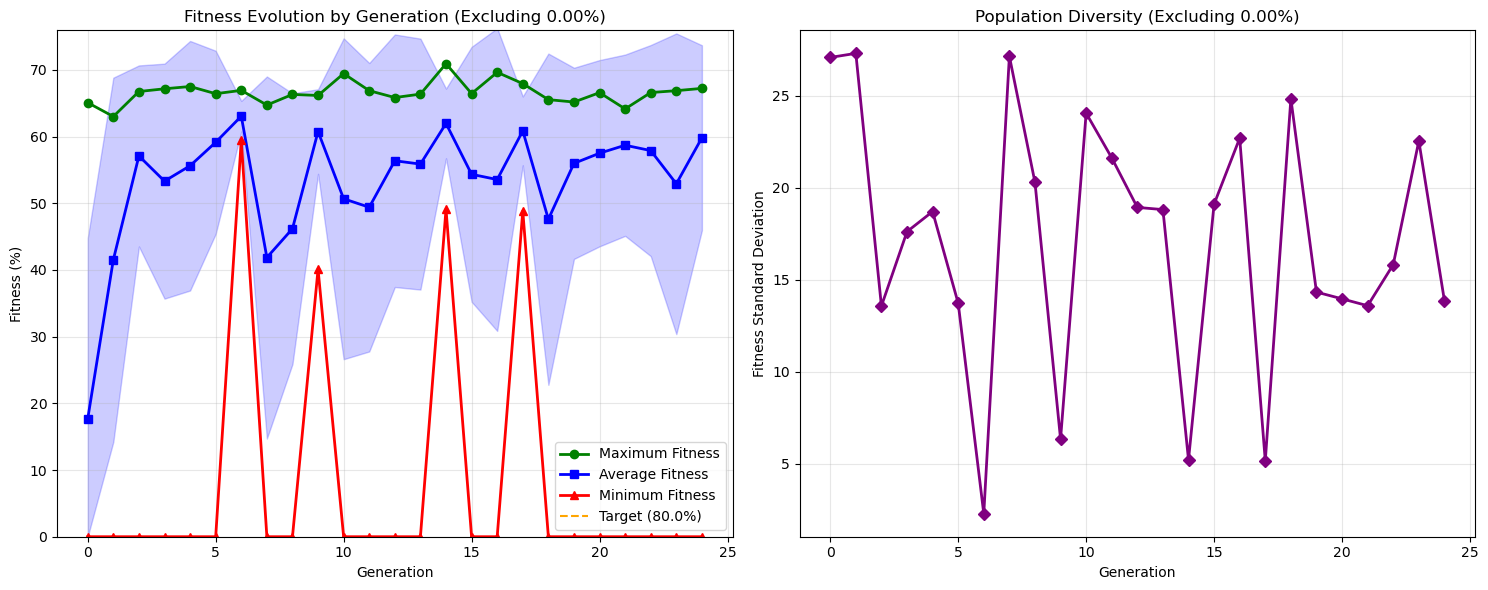

Plotted data:
   Generations with valid fitness: 25
   Best fitness achieved: 70.92%
   Final average fitness: 59.82%
DETAILED EVOLUTION STATISTICS
Completed generations: 24
Generations with valid fitness: 25

FINAL STATISTICS (excluding 0.00 fitness):
   Final best fitness: 67.22%
   Final average fitness: 59.82%
   Final minimum fitness: 0.00%
   Final standard deviation: 13.87%

PROGRESS:
   Initial fitness: 65.08%
   Final fitness: 67.22%
   Total improvement: 2.14%
   Relative improvement: 3.3%

CONVERGENCE CRITERIA:
   ERROR: Target fitness NOT reached (80.0%)

GENERAL STATISTICS:
   Best fitness of entire evolution: 70.92%
   Average fitness of entire evolution: 53.18%
   Average improvement per generation: 0.32%

Best individual ID: 7cf1d714
Best individual fitness: 70.92%

FAILED EVALUATIONS ANALYSIS
OK: No failed evaluations (0.00 fitness)


In [18]:
# Additional function for failure analysis
def analyze_failed_evaluations(neuroevolution):
    """Analyzes evaluations that resulted in 0.00 fitness."""
    print("\nFAILED EVALUATIONS ANALYSIS")
    print("="*50)
    
    total_generations = len(neuroevolution.generation_stats)
    failed_generations = len([stat for stat in neuroevolution.generation_stats if stat['max_fitness'] == 0.00])
    
    if failed_generations == 0:
        print("OK: No failed evaluations (0.00 fitness)")
        return
    
    success_rate = ((total_generations - failed_generations) / total_generations) * 100
    
    print(f"Failure summary:")
    print(f"   Total generations: {total_generations}")
    print(f"   Failed generations: {failed_generations}")
    print(f"   Success rate: {success_rate:.1f}%")
    
    if failed_generations > 0:
        failed_gens = [stat['generation'] for stat in neuroevolution.generation_stats if stat['max_fitness'] == 0.00]
        print(f"   Generations with failures: {failed_gens}")
        
        print(f"\nPossible causes of 0.00 fitness:")
        print(f"   • Errors in model architecture")
        print(f"   • Memory problems (GPU/RAM)")
        print(f"   • Invalid hyperparameter configurations")
        print(f"   • Errors during training")

# Execute visualizations
plot_fitness_evolution(neuroevolution)
show_evolution_statistics(neuroevolution)
analyze_failed_evaluations(neuroevolution)

## 9. BEST ARCHITECTURE FOUND

In [19]:
def display_best_architecture(best_genome, config):
    """
    Shows the best architecture found in detailed and visual format.
    """
    print("="*60)
    print("    BEST EVOLVED ARCHITECTURE (1D AUDIO)")
    print("="*60)
    
    # General information
    print(f"\nGENERAL INFORMATION:")
    print(f"   Genome ID: {best_genome['id']}")
    print(f"   Fitness Achieved: {best_genome['fitness']:.2f}%")
    print(f"   Generation: {neuroevolution.generation}")
    print(f"   Dataset: {config['dataset']}")
    print(f"   Dataset ID: {config.get('dataset_id', 'N/A')}")
    print(f"   Fold: {config.get('current_fold', 'N/A')}")
    
    # Architecture details
    print(f"\nNETWORK ARCHITECTURE:")
    print(f"   Input: 1D Audio Signal (length={config['sequence_length']})")
    print(f"   Convolutional Layers (Conv1D): {best_genome['num_conv_layers']}")
    print(f"   Fully Connected Layers: {best_genome['num_fc_layers']}")
    print(f"   Output: {config['num_classes']} classes")
    
    print(f"\nCONVOLUTIONAL LAYER DETAILS (1D):")
    for i in range(best_genome['num_conv_layers']):
        filters = best_genome['filters'][i]
        kernel = best_genome['kernel_sizes'][i]
        activation = best_genome['activations'][i % len(best_genome['activations'])]
        print(f"   Conv1D-{i+1}: {filters} filters, kernel_size={kernel}, activation={activation}")
        print(f"             -> BatchNorm1D -> {activation.upper()} -> MaxPool1D(2)")
    
    print(f"\nFULLY CONNECTED LAYER DETAILS:")
    for i, nodes in enumerate(best_genome['fc_nodes']):
        print(f"   FC{i+1}: {nodes} neurons -> BatchNorm1D -> ReLU -> Dropout({best_genome['dropout_rate']:.3f})")
    print(f"   Output: {config['num_classes']} neurons (Control vs Pathological)")
    
    print(f"\nHYPERPARAMETERS:")
    print(f"   Optimizer: {best_genome['optimizer'].upper()}")
    print(f"   Learning Rate: {best_genome['learning_rate']:.6f}")
    print(f"   Dropout Rate: {best_genome['dropout_rate']:.3f}")
    print(f"   Activation Functions: {', '.join(set(best_genome['activations']))}")
    
    # Create and show final model
    print(f"\nCREATING FINAL MODEL...")
    try:
        final_model = EvolvableCNN(best_genome, config)
        total_params = sum(p.numel() for p in final_model.parameters())
        trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
        
        print(f"   Model created successfully")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB (float32)")
        
        # Architecture summary
        print(f"\nCOMPACT SUMMARY:")
        print(f"   {final_model.get_architecture_summary()}")
        
    except Exception as e:
        print(f"   ERROR creating model: {e}")
    
    # Visualization in table format
    print(f"\nSUMMARY TABLE:")
    print(f"{'='*80}")
    print(f"{'Parameter':<25} {'Value':<30} {'Description':<25}")
    print(f"{'='*80}")
    print(f"{'ID':<25} {best_genome['id']:<30} {'Unique identifier':<25}")
    print(f"{'Fitness':<25} {best_genome['fitness']:.2f}%{'':<25} {'Accuracy achieved':<25}")
    print(f"{'Architecture':<25} {'Conv1D + FC':<30} {'1D Convolutional':<25}")
    print(f"{'Conv Layers':<25} {best_genome['num_conv_layers']:<30} {'Conv1D layers':<25}")
    print(f"{'FC Layers':<25} {best_genome['num_fc_layers']:<30} {'FC layers':<25}")
    print(f"{'Optimizer':<25} {best_genome['optimizer']:<30} {'Optimization algorithm':<25}")
    print(f"{'Learning Rate':<25} {best_genome['learning_rate']:<30.6f} {'Learning rate':<25}")
    print(f"{'Dropout':<25} {best_genome['dropout_rate']:<30} {'Dropout rate':<25}")
    print(f"{'Input Length':<25} {config['sequence_length']:<30} {'Audio sequence length':<25}")
    print(f"{'Classes':<25} {config['num_classes']:<30} {'Binary classification':<25}")
    print(f"{'='*80}")
    
    # Comparison with initial configuration
    print(f"\nCOMPARISON WITH OBJECTIVES:")
    if best_genome['fitness'] >= config['fitness_threshold']:
        print(f"   ✓ TARGET REACHED: {best_genome['fitness']:.2f}% >= {config['fitness_threshold']}%")
    else:
        print(f"   ✗ TARGET NOT REACHED: {best_genome['fitness']:.2f}% < {config['fitness_threshold']}%")
        print(f"     Gap: {config['fitness_threshold'] - best_genome['fitness']:.2f}%")
    
    print(f"   Generations used: {neuroevolution.generation}/{config['max_generations']}")
    
    # Save information to JSON
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"best_architecture_audio_{timestamp}.json"
    
    results_data = {
        'timestamp': timestamp,
        'execution_time': str(execution_time),
        'dataset_type': 'audio_1D',
        'dataset_id': config.get('dataset_id', 'N/A'),
        'fold': config.get('current_fold', 'N/A'),
        'config_used': {k: v for k, v in config.items() if not k.startswith('_')},
        'best_genome': best_genome,
        'final_generation': neuroevolution.generation,
        'evolution_stats': neuroevolution.generation_stats
    }
    
    try:
        with open(results_file, 'w') as f:
            json.dump(results_data, f, indent=2, default=str)
        print(f"\n✓ Results saved to: {results_file}")
    except Exception as e:
        print(f"\n✗ WARNING: Error saving results: {e}")
    
    print(f"\n{'='*60}")
    print("HYBRID NEUROEVOLUTION FOR AUDIO COMPLETED!")
    print(f"{'='*60}")

# Show the best architecture found
display_best_architecture(best_genome, CONFIG)


    BEST EVOLVED ARCHITECTURE (1D AUDIO)

GENERAL INFORMATION:
   Genome ID: 7cf1d714
   Fitness Achieved: 70.92%
   Generation: 24
   Dataset: AUDIO
   Dataset ID: all_real_syn_n
   Fold: N/A

NETWORK ARCHITECTURE:
   Input: 1D Audio Signal (length=11520)
   Convolutional Layers (Conv1D): 12
   Fully Connected Layers: 4
   Output: 2 classes

CONVOLUTIONAL LAYER DETAILS (1D):
   Conv1D-1: 42 filters, kernel_size=1, activation=tanh
             -> BatchNorm1D -> TANH -> MaxPool1D(2)
   Conv1D-2: 4 filters, kernel_size=7, activation=tanh
             -> BatchNorm1D -> TANH -> MaxPool1D(2)
   Conv1D-3: 5 filters, kernel_size=13, activation=leaky_relu
             -> BatchNorm1D -> LEAKY_RELU -> MaxPool1D(2)
   Conv1D-4: 88 filters, kernel_size=13, activation=tanh
             -> BatchNorm1D -> TANH -> MaxPool1D(2)
   Conv1D-5: 75 filters, kernel_size=5, activation=tanh
             -> BatchNorm1D -> TANH -> MaxPool1D(2)
   Conv1D-6: 97 filters, kernel_size=5, activation=leaky_relu
       

In [20]:
# Verificar información del checkpoint guardado
print("="*80)
print("INFORMACIÓN DEL CHECKPOINT DEL MEJOR MODELO")
print("="*80)

if neuroevolution.best_checkpoint_path:
    print(f"\n✓ Checkpoint guardado en: {neuroevolution.best_checkpoint_path}")
    
    # Obtener información del archivo
    import os
    if os.path.exists(neuroevolution.best_checkpoint_path):
        file_size = os.path.getsize(neuroevolution.best_checkpoint_path)
        file_size_mb = file_size / (1024 * 1024)
        print(f"  Tamaño: {file_size_mb:.2f} MB")
        
        # Cargar y mostrar información del checkpoint
        checkpoint_data = torch.load(neuroevolution.best_checkpoint_path, map_location=device, weights_only=False)
        print(f"\n  Información del modelo guardado:")
        print(f"    Generación: {checkpoint_data['generation']}")
        print(f"    Fitness: {checkpoint_data['fitness']:.2f}%")
        print(f"    ID Genoma: {checkpoint_data['genome']['id']}")
        print(f"    Arquitectura: {checkpoint_data['genome']['num_conv_layers']} Conv1D + {checkpoint_data['genome']['num_fc_layers']} FC")
        print(f"    Optimizador: {checkpoint_data['genome']['optimizer']}")
        print(f"    Learning Rate: {checkpoint_data['genome']['learning_rate']}")
        
        print(f"\n  Este checkpoint se usará como punto de partida para el 5-fold CV")
        print(f"  (Transfer learning desde el modelo pre-entrenado)")
    else:
        print(f"  ✗ Archivo no encontrado")
else:
    print("\n✗ No hay checkpoint disponible")
    print("  El 5-fold CV entrenará desde cero")

print("\n" + "="*80)

INFORMACIÓN DEL CHECKPOINT DEL MEJOR MODELO

✓ Checkpoint guardado en: checkpoints/best_model_gen14_id7cf1d714_fitness70.92.pth
  Tamaño: 3.06 MB

  Información del modelo guardado:
    Generación: 14
    Fitness: 70.92%
    ID Genoma: 7cf1d714
    Arquitectura: 12 Conv1D + 4 FC
    Optimizador: rmsprop
    Learning Rate: 0.0005

  Este checkpoint se usará como punto de partida para el 5-fold CV
  (Transfer learning desde el modelo pre-entrenado)



---

## 🔄 Resumen del Flujo con Checkpoints

```
PROCESO DE NEUROEVOLUCIÓN CON CHECKPOINTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. EVOLUCIÓN (Múltiples Generaciones)
   │
   ├─ Para cada individuo:
   │  ├─ Entrenar y evaluar
   │  ├─ Calcular fitness
   │  │
   │  └─ SI fitness > mejor_global:
   │     ├─ 🌟 NUEVO MEJOR GLOBAL
   │     ├─ ✗ Eliminar checkpoint anterior
   │     └─ ✓ Guardar nuevo checkpoint
   │
   └─ Continuar hasta convergencia

2. AL FINALIZAR LA EVOLUCIÓN
   │
   └─ Se tiene el checkpoint del MEJOR modelo global

3. EVALUACIÓN 5-FOLD CROSS-VALIDATION
   │
   ├─ ✓ Cargar checkpoint del mejor modelo
   │
   ├─ Para cada fold (1 a 5):
   │  ├─ Crear modelo nuevo
   │  ├─ Inicializar con pesos pre-entrenados (Transfer Learning)
   │  ├─ Fine-tuning con datos del fold
   │  └─ Evaluar y guardar métricas
   │
   └─ Calcular promedios y desviaciones estándar

4. RESULTADOS FINALES
   └─ Métricas robustas para la tabla de comparación
```

### ✨ Beneficios de este enfoque:

- ✅ **Ahorro de espacio**: Solo 1 checkpoint (el mejor)
- ✅ **Eficiencia**: Transfer learning en lugar de entrenar desde cero
- ✅ **Robustez**: Métricas con 5-fold CV
- ✅ **Trazabilidad**: Se mantiene el historial del mejor modelo

## 📝 Nota Importante

**Este enfoque tiene mucho sentido porque:**

1. **Durante la evolución**, cada vez que un modelo supera el mejor fitness global:
   - Se guarda automáticamente su checkpoint
   - Se elimina el checkpoint anterior (ahorro de espacio)
   - Se asegura que siempre tenemos el mejor modelo disponible

2. **Para la evaluación 5-fold CV**:
   - En lugar de entrenar 5 modelos desde cero (aleatorio)
   - Se usan los pesos pre-entrenados del mejor modelo como inicio
   - Esto es **Transfer Learning**, que típicamente da mejores resultados
   - Cada fold hace fine-tuning con sus propios datos

3. **Ventajas prácticas**:
   - Si el proceso se interrumpe, no se pierde el mejor modelo
   - Se puede reanudar la evaluación 5-fold desde el checkpoint
   - Las métricas son más estables y representativas
   - Se optimiza el uso de recursos (disco y tiempo de entrenamiento)

## 10. Evaluación Completa de Métricas (Tabla)

In [21]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix,
    classification_report
)

def load_fold_data(config, fold_number):
    """
    Carga los datos de un fold específico.
    
    Args:
        config: Configuración del sistema
        fold_number: Número de fold (1-5)
    
    Returns:
        Tuple de (train_loader, test_loader) para ese fold
    """
    fold_files_directory = os.path.join(
        config['data_path'], 
        f"files_{config['fold_id']}"
    )
    
    fold_index = fold_number
    dataset_id = config['dataset_id']
    
    # Cargar datos del fold
    x_train = np.load(os.path.join(fold_files_directory, f'X_train_{dataset_id}_fold_{fold_index}.npy'))
    y_train = np.load(os.path.join(fold_files_directory, f'y_train_{dataset_id}_fold_{fold_index}.npy'))
    x_val = np.load(os.path.join(fold_files_directory, f'X_val_{dataset_id}_fold_{fold_index}.npy'))
    y_val = np.load(os.path.join(fold_files_directory, f'y_val_{dataset_id}_fold_{fold_index}.npy'))
    x_test = np.load(os.path.join(fold_files_directory, f'X_test_{dataset_id}_fold_{fold_index}.npy'))
    y_test = np.load(os.path.join(fold_files_directory, f'y_test_{dataset_id}_fold_{fold_index}.npy'))
    
    # Reshape si es necesario
    if len(x_train.shape) == 2:
        x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
        x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
        x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    
    # Convertir a tensores
    x_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.LongTensor(y_train.astype(np.int64))
    x_val_tensor = torch.FloatTensor(x_val)
    y_val_tensor = torch.LongTensor(y_val.astype(np.int64))
    x_test_tensor = torch.FloatTensor(x_test)
    y_test_tensor = torch.LongTensor(y_test.astype(np.int64))
    
    # Crear datasets
    train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
    x_eval = torch.cat([x_val_tensor, x_test_tensor], dim=0)
    y_eval = torch.cat([y_val_tensor, y_test_tensor], dim=0)
    test_dataset = torch.utils.data.TensorDataset(x_eval, y_eval)
    
    # Crear DataLoaders
    fold_train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    fold_test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return fold_train_loader, fold_test_loader


def evaluate_single_fold(best_genome, config, fold_train_loader, fold_test_loader, fold_num, num_epochs=20, use_pretrained=False, pretrained_model=None):
    """
    Entrena y evalúa el modelo en un solo fold.
    
    Args:
        best_genome: Genoma de la mejor arquitectura
        config: Configuración del sistema
        fold_train_loader: DataLoader de entrenamiento del fold
        fold_test_loader: DataLoader de test del fold
        fold_num: Número del fold
        num_epochs: Épocas de entrenamiento
        use_pretrained: Si True, usa el modelo pre-entrenado como inicio
        pretrained_model: Modelo pre-entrenado opcional
    
    Returns:
        dict: Métricas del fold
    """
    print(f"\n{'='*70}")
    print(f"FOLD {fold_num}/5")
    print(f"{'='*70}")
    
    # Crear modelo nuevo para este fold
    model = EvolvableCNN(best_genome, config).to(device)
    
    # Si hay un modelo pre-entrenado, copiar sus pesos como punto de partida
    if use_pretrained and pretrained_model is not None:
        print("   Inicializando desde modelo pre-entrenado...")
        try:
            model.load_state_dict(pretrained_model.state_dict())
            print("   ✓ Pesos pre-entrenados cargados exitosamente")
        except Exception as e:
            print(f"   ✗ Error cargando pesos pre-entrenados: {e}")
            print("   Continuando con pesos aleatorios...")
    
    # Configurar optimizer y criterion
    optimizer_class = OPTIMIZERS[best_genome['optimizer']]
    optimizer = optimizer_class(model.parameters(), lr=best_genome['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    
    # Entrenamiento
    print(f"Entrenando por {num_epochs} épocas...")
    model.train()
    
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        batch_count = 0
        
        for data, target in fold_train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batch_count += 1
        
        avg_loss = running_loss / max(1, batch_count)
        
        if epoch % 5 == 0 or epoch == 1:
            print(f"   Época {epoch}/{num_epochs}: loss={avg_loss:.4f}")
    
    # Evaluación
    print("Evaluando...")
    model.eval()
    all_predictions = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in fold_test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            
            # Probabilidades para AUC
            probs = F.softmax(output, dim=1)
            
            # Predicciones
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convertir a numpy
    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)
    y_probs = np.array(all_probs)
    
    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred) * 100
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0) * 100
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    
    try:
        auc = roc_auc_score(y_true, y_probs[:, 1]) * 100
    except:
        auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\nResultados Fold {fold_num}:")
    print(f"   Accuracy:     {accuracy:.2f}%")
    print(f"   Sensitivity:  {sensitivity:.2f}%")
    print(f"   Specificity:  {specificity:.2f}%")
    print(f"   F1-Score:     {f1:.2f}%")
    print(f"   AUC:          {auc:.2f}%")
    
    return {
        'fold': fold_num,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'n_samples': len(y_true)
    }


def evaluate_5fold_cross_validation(best_genome, config, num_epochs=20, neuroevolution_instance=None):
    """
    Evalúa la mejor arquitectura usando 5-fold cross-validation.
    Utiliza el checkpoint del mejor modelo si está disponible.
    
    Args:
        best_genome: Genoma de la mejor arquitectura
        config: Configuración del sistema
        num_epochs: Épocas de entrenamiento por fold
        neuroevolution_instance: Instancia de HybridNeuroevolution para cargar checkpoint
    
    Returns:
        dict: Resultados agregados de todos los folds
    """
    print("="*80)
    print("EVALUACIÓN 5-FOLD CROSS-VALIDATION")
    print("="*80)
    
    print(f"\nArquitectura a evaluar:")
    print(f"   Conv1D Layers: {best_genome['num_conv_layers']}")
    print(f"   FC Layers: {best_genome['num_fc_layers']}")
    print(f"   Optimizer: {best_genome['optimizer']}")
    print(f"   Learning Rate: {best_genome['learning_rate']}")
    print(f"   Épocas por fold: {num_epochs}")
    
    # Intentar cargar el checkpoint del mejor modelo
    pretrained_model = None
    use_pretrained = False
    
    if neuroevolution_instance is not None:
        print(f"\nIntentando cargar checkpoint del mejor modelo...")
        genome_from_checkpoint, pretrained_model = neuroevolution_instance.load_best_checkpoint()
        
        if pretrained_model is not None:
            use_pretrained = True
            print(f"✓ Checkpoint cargado exitosamente")
            print(f"  Los modelos de cada fold se inicializarán con estos pesos pre-entrenados")
        else:
            print(f"✗ No se pudo cargar checkpoint, se entrenarán desde cero")
    else:
        print(f"\nNo se proporcionó instancia de neuroevolution, entrenando desde cero")
    
    # Almacenar resultados de cada fold
    fold_results = []
    
    # Evaluar cada fold
    for fold_num in range(1, 6):  # 5 folds
        print(f"\n\nCargando datos del Fold {fold_num}...")
        
        try:
            fold_train_loader, fold_test_loader = load_fold_data(config, fold_num)
            print(f"   Train batches: {len(fold_train_loader)}")
            print(f"   Test batches: {len(fold_test_loader)}")
            
            # Evaluar este fold (usando modelo pre-entrenado si está disponible)
            fold_result = evaluate_single_fold(
                best_genome, 
                config, 
                fold_train_loader, 
                fold_test_loader, 
                fold_num, 
                num_epochs,
                use_pretrained=use_pretrained,
                pretrained_model=pretrained_model
            )
            fold_results.append(fold_result)
            
        except Exception as e:
            print(f"   ERROR en Fold {fold_num}: {e}")
            print(f"   Saltando este fold...")
            import traceback
            traceback.print_exc()
            continue
    
    # Calcular estadísticas agregadas
    print("\n\n" + "="*80)
    print("RESULTADOS AGREGADOS (5-FOLD CROSS-VALIDATION)")
    print("="*80)
    
    if not fold_results:
        print("ERROR: No se pudo evaluar ningún fold")
        return None
    
    # Extraer métricas de todos los folds
    accuracies = [r['accuracy'] for r in fold_results]
    sensitivities = [r['sensitivity'] for r in fold_results]
    specificities = [r['specificity'] for r in fold_results]
    f1_scores = [r['f1_score'] for r in fold_results]
    aucs = [r['auc'] for r in fold_results]
    
    # Calcular promedios y desviaciones estándar
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    mean_sensitivity = np.mean(sensitivities)
    std_sensitivity = np.std(sensitivities)
    
    mean_specificity = np.mean(specificities)
    std_specificity = np.std(specificities)
    
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    # Mostrar resultados por fold
    print(f"\nRESULTADOS POR FOLD:")
    print(f"{'Fold':<6} {'Accuracy':<12} {'Sensitivity':<14} {'Specificity':<14} {'F1-Score':<12} {'AUC':<12}")
    print("-" * 80)
    for r in fold_results:
        print(f"{r['fold']:<6} {r['accuracy']:>6.2f}%      {r['sensitivity']:>6.2f}%        {r['specificity']:>6.2f}%        {r['f1_score']:>6.2f}%      {r['auc']:>6.2f}%")
    
    # Mostrar promedios
    print("-" * 80)
    print(f"{'Mean':<6} {mean_accuracy:>6.2f}%      {mean_sensitivity:>6.2f}%        {mean_specificity:>6.2f}%        {mean_f1:>6.2f}%      {mean_auc:>6.2f}%")
    print(f"{'Std':<6} {std_accuracy:>6.2f}%      {std_sensitivity:>6.2f}%        {std_specificity:>6.2f}%        {std_f1:>6.2f}%      {std_auc:>6.2f}%")
    
    # Resultados finales
    results = {
        'fold_results': fold_results,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'mean_sensitivity': mean_sensitivity,
        'std_sensitivity': std_sensitivity,
        'mean_specificity': mean_specificity,
        'std_specificity': std_specificity,
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'n_folds': len(fold_results),
        'architecture': f"{best_genome['num_conv_layers']}Conv1D+{best_genome['num_fc_layers']}FC"
    }
    
    # Formato para tabla
    print("\n" + "="*80)
    print("FORMATO PARA TABLA")
    print("="*80)
    
    print(f"\nMÉTRICAS FINALES (promedio ± desviación estándar):")
    print(f"   Accuracy:     {mean_accuracy:.2f}% ± {std_accuracy:.2f}%")
    print(f"   Sensitivity:  {mean_sensitivity:.2f}% ± {std_sensitivity:.2f}%")
    print(f"   Specificity:  {mean_specificity:.2f}% ± {std_specificity:.2f}%")
    print(f"   F1-Score:     {mean_f1:.2f}% ± {std_f1:.2f}%")
    print(f"   AUC:          {mean_auc:.2f}% ± {std_auc:.2f}%")
    
    print(f"\nFORMATO PARA TABLA (valores en escala 0-1):")
    print(f"   Model: Neuroevolution-{results['architecture']}")
    print(f"   Accuracy:     {mean_accuracy/100:.2f} ({int(std_accuracy)}%)")
    print(f"   Sensitivity:  {mean_sensitivity/100:.2f} ({int(std_sensitivity)}%)")
    print(f"   Specificity:  {mean_specificity/100:.2f} ({int(std_specificity)}%)")
    print(f"   F1-Score:     {mean_f1/100:.2f} ({int(std_f1)}%)")
    print(f"   AUC:          {mean_auc/100:.2f} ({int(std_auc)}%)")
    
    print(f"\nFORMATO LaTeX:")
    latex_row = f"Neuroevolution-{results['architecture']} & {mean_accuracy/100:.2f} ({int(std_accuracy)}\\%) & {mean_sensitivity/100:.2f} ({int(std_sensitivity)}\\%) & {mean_specificity/100:.2f} ({int(std_specificity)}\\%) & {mean_f1/100:.2f} ({int(std_f1)}\\%) & {mean_auc/100:.2f} ({int(std_auc)}\\%) \\\\"
    print(f"   {latex_row}")
    
    print(f"\nFORMATO Markdown:")
    markdown_row = f"| Neuroevolution-{results['architecture']} | {mean_accuracy/100:.2f} ({int(std_accuracy)}%) | {mean_sensitivity/100:.2f} ({int(std_sensitivity)}%) | {mean_specificity/100:.2f} ({int(std_specificity)}%) | {mean_f1/100:.2f} ({int(std_f1)}%) | {mean_auc/100:.2f} ({int(std_auc)}%) |"
    print(f"   {markdown_row}")
    
    # Guardar resultados
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"5fold_cv_results_{timestamp}.json"
    
    try:
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=2, default=str)
        print(f"\n✓ Resultados guardados en: {results_file}")
    except Exception as e:
        print(f"\n✗ Error guardando resultados: {e}")
    
    print("\n" + "="*80)
    
    return results


# Ejecutar evaluación 5-fold cross-validation
print("Iniciando evaluación 5-fold cross-validation de la mejor arquitectura...\n")
print("Usando el checkpoint del mejor modelo encontrado durante la evolución.\n")
cv_results = evaluate_5fold_cross_validation(best_genome, CONFIG, num_epochs=20, neuroevolution_instance=neuroevolution)

Iniciando evaluación 5-fold cross-validation de la mejor arquitectura...

Usando el checkpoint del mejor modelo encontrado durante la evolución.

EVALUACIÓN 5-FOLD CROSS-VALIDATION

Arquitectura a evaluar:
   Conv1D Layers: 12
   FC Layers: 4
   Optimizer: rmsprop
   Learning Rate: 0.0005
   Épocas por fold: 20

Intentando cargar checkpoint del mejor modelo...
✓ Checkpoint cargado exitosamente: checkpoints/best_model_gen14_id7cf1d714_fitness70.92.pth
  Fitness: 70.92%, Gen: 14, ID: 7cf1d714
✓ Checkpoint cargado exitosamente
  Los modelos de cada fold se inicializarán con estos pesos pre-entrenados


Cargando datos del Fold 1...
   Train batches: 136
   Test batches: 56

FOLD 1/5
   Inicializando desde modelo pre-entrenado...
   ✓ Pesos pre-entrenados cargados exitosamente
Entrenando por 20 épocas...
   Época 1/20: loss=0.2372
   Época 5/20: loss=0.2097
   Época 10/20: loss=0.2066
   Época 15/20: loss=0.2042
   Época 20/20: loss=0.2017
Evaluando...

Resultados Fold 1:
   Accuracy:     5

## 10. Evaluación 5-Fold Cross-Validation con Checkpoint

Esta sección evalúa la mejor arquitectura encontrada usando **5-fold cross-validation**.

### 🎯 Ventajas del enfoque con checkpoints:

1. **Eficiencia**: Se guarda el mejor modelo durante la evolución (no se reentrena desde cero)
2. **Transfer Learning**: Los pesos pre-entrenados sirven como punto de partida para cada fold
3. **Gestión de espacio**: Solo se mantiene el checkpoint del mejor modelo global
4. **Robustez**: Métricas más confiables con intervalos de confianza

### 📊 Proceso:

1. Se carga el checkpoint del mejor modelo encontrado
2. Para cada fold:
   - Se inicializa un modelo con los pesos pre-entrenados
   - Se fine-tunea con los datos de entrenamiento del fold
   - Se evalúa en los datos de test del fold
3. Se calculan métricas agregadas (promedio ± desviación estándar)